## Functions and Data

In [2]:
import os
import datetime
import copy


import numpy as np
from numpy.random import normal as rnorm, multinomial as rmultinomial
import scipy.stats
from scipy.special import logsumexp, loggamma
from sklearn.mixture import GaussianMixture
from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score, roc_curve
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge, LogisticRegression, LogisticRegressionCV
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR
from sklearn.model_selection import KFold

import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm


plt.style.use(['seaborn-talk'])

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)


C:\Users\noah_\AppData\Local\Temp\ipykernel_28592\3403931679.py:23: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-talk'])


In [3]:
data_W = pd.read_excel(r"data/Hourly Weather and No Outlier Wachapreague Data.xlsx", parse_dates=[r"Date"])
data_W = data_W.drop(
    columns=["Wind Direction (degrees)", "Water Level Anomalies (m)"]
    ).rename(
    columns = {"Date": "time_min", 
                "Wind Speed (m/s)": "wind",
               "Air Pressure (mb)": "airpressure",
               "Precipitation (mm/hr)": "precipitation", 
               "Temperature ©": "temperature",
               "Salinity (ppt)": "salinity",
               "DO (mg/L)": "ODO",
               "Water Level (m)": "waterlevel",
               "Log10(Chl+1) (log10(ug/L))": "log10_chlorophyll",
              }
    ).set_index("time_min")

data_W["chlorophyll"] = data_W["log10_chlorophyll"].map(lambda x: np.power(10, x))
data_W["date"] = data_W.index.date
#data_W = data_W.dropna()

# data_W = pd.read_excel(r"data/Corrected W All.xlsx", sheet_name = "Sheet1", parse_dates=[r"Combine"],)
# data_W = data_W.drop(
#     columns=["MM/DD/YY", "HH:mm:SS", "pH (mv)", "ODO (%sat)", "BGA-PE (ug/L)", "Battery (volts)", "Sonde SN", "Unnamed: 15"]
#     ).rename(
#     columns = {"Combine": "time_min",
#                "Temp ('C)": "temperature",
#                "SpCond (ms/cm)": "conductivity",
#                "Salinity (ppt)": "salinity",
#                "ODO (mg/L)": "ODO",
#                "Turb (NTU)": "turbidity",
#                "Chl (ug/L)": "chlorophyll",
#               }
#     ).set_index("time_min")
# data_W["date"] = data_W.index.date
# data_W["log10_chlorophyll"] = data_W["chlorophyll"].map(np.log10)
# data_W = data_W.dropna()


In [4]:
data_W

,wind,airpressure,precipitation,temperature,salinity,ODO,log10_chlorophyll,waterlevel,chlorophyll,date
time_min,,,,,,,,,,
2016-03-25 20:00:00,1.870,1012.210000,0.76,16.70975,30.9550,8.0425,0.360495,0.938,2.293480,2016-03-25
2016-03-25 21:00:00,2.500,1013.730000,0.53,16.43975,31.2575,7.8200,0.319070,1.127,2.084826,2016-03-25
2016-03-25 22:00:00,3.690,1014.980000,0.20,15.83275,31.4425,7.8650,0.327645,1.268,2.126401,2016-03-25
2016-03-25 23:00:00,4.180,1015.490000,0.03,15.43950,31.4775,7.8525,0.330899,1.324,2.142390,2016-03-25
2016-03-26 00:00:00,3.150,1016.750000,0.00,15.45900,31.3925,7.7400,0.325592,1.238,2.116372,2016-03-26
...,...,...,...,...,...,...,...,...,...,...
2022-12-31 18:00:00,0.625,1011.325000,0.02,7.93175,30.2575,10.6000,0.358752,0.8,2.284292,2022-12-31
2022-12-31 19:00:00,1.800,1011.310000,NaN,8.10550,30.1100,10.5450,0.359835,NaN,2.289997,2022-12-31
2022-12-31 20:00:00,2.120,1010.420000,NaN,8.65100,28.9200,10.2250,0.429598,NaN,2.689042,2022-12-31


In [5]:

data_WW = pd.read_excel(r"data/VIMS WQ Data.xlsx", sheet_name = "WW", skiprows = 7, na_values = {"pH": [0.0]}, parse_dates=[r"Date/Time Combined", r"MM/DD/YY"], )
data_WW_2 = pd.read_excel(r"data/2022-Willis_Wharf ALL Raw (1).xlsx", skiprows = 7, na_values = {"pH": [0.0]}, parse_dates=[r"Date/Time Combined", r"MM/DD/YY"], )

data_WW = data_WW.drop(
    columns=["Unnamed: 17", "Unnamed: 18", "MM/DD/YY.1", "Flagged or Deleted Data/Notes", "Log10 chl", 
             "pH (mv)", "ODO (%sat)", "BGA-PE (ug/L)", "Battery (volts)", "Sonde SN", "HH:mm:SS", "TSS (mg/L)", "Day"],
    ).rename(
    columns = {"MM/DD/YY": "date", 
               "Date/Time Combined": "time_min",
               "Temp ('C)": "temperature",
               "SpCond (ms/cm)": "conductivity",
               "Salinity (ppt)": "salinity",
               "ODO (mg/L)": "ODO",
               "Turb (NTU)": "turbidity",
               "Chl (ug/L)": "chlorophyll",
              }
    ).set_index("time_min")

data_WW_2 = data_WW_2.drop(
    columns=["Unnamed: 16", "Unnamed: 17", "Unnamed: 18", "Unnamed: 19", "Unnamed: 20", 
             "pH (mv)", "ODO (%sat)", "BGA-PE (ug/L)", "Battery (volts)", "Sonde SN", "HH:mm:SS", "TSS (mg/L)"],
    ).rename(
    columns = {"MM/DD/YY": "date", 
               "Date/Time Combined": "time_min",
               "Temp ('C)": "temperature",
               "SpCond (ms/cm)": "conductivity",
               "Salinity (ppt)": "salinity",
               "ODO (mg/L)": "ODO",
               "Turb (NTU)": "turbidity",
               "Chl (ug/L)": "chlorophyll",
              }
    ).set_index("time_min")

data_WW = pd.concat([data_WW[data_WW.index.year < 2022], data_WW_2])
data_WW["log10_chlorophyll"] = data_WW["chlorophyll"].map(np.log10)
#data_WW = data_WW.dropna()


d:\Tools\anaconda3\lib\site-packages\pandas\core\base.py:880: RuntimeWarning: divide by zero encountered in log10
  new_values = map_f(values, mapper)
d:\Tools\anaconda3\lib\site-packages\pandas\core\base.py:880: RuntimeWarning: invalid value encountered in log10
  new_values = map_f(values, mapper)


In [6]:
data_WW

,date,temperature,conductivity,salinity,pH,ODO,turbidity,chlorophyll,log10_chlorophyll
time_min,,,,,,,,,
2018-10-12 12:53:04,2018-10-12,24.221,46.978,30.55,7.81,5.84,21.72,3.87,0.587711
2018-10-12 14:03:38,2018-10-12,24.615,46.755,30.38,7.86,6.37,19.17,6.34,0.802089
2018-10-12 14:17:40,2018-10-12,24.757,46.513,30.20,7.85,6.54,20.72,6.97,0.843233
2018-10-12 14:32:41,2018-10-12,24.898,46.381,30.10,7.85,6.71,21.37,7.67,0.884795
2018-10-12 14:47:41,2018-10-12,24.940,46.315,30.05,7.86,6.81,23.71,7.33,0.865104
...,...,...,...,...,...,...,...,...,...
2022-12-24 05:02:12,2022-12-24,4.105,46.071,29.17,7.84,9.80,17.23,3.00,0.477121
2022-12-24 05:17:12,2022-12-24,3.908,46.023,29.11,7.84,9.79,17.85,3.09,0.489958
2022-12-24 05:32:12,2022-12-24,3.921,46.073,29.15,7.83,9.72,21.78,3.06,0.485721


In [7]:

data_WW_byday = data_WW[["date", "conductivity", "turbidity"]].resample("1D").max()
data_WW_byday["temperature"] = data_WW["temperature"].resample("1D").mean()
data_WW_byday["pH"] = data_WW["pH"].resample("1D").mean()
data_WW_byday["ODO"] = data_WW["ODO"].resample("1D").min()
data_WW_byday["salinity_max"] = data_WW["salinity"].resample("1D").max()
data_WW_byday["salinity_min"] = data_WW["salinity"].resample("1D").min()
data_WW_byday["log10_chlorophyll"] = data_WW["log10_chlorophyll"].resample("1D").max()
data_WW_byday["chlorophyll"] = data_WW["chlorophyll"].resample("1D").max()

# data_WW_byday = data_WW[["temperature", "pH"]].resample("1D").mean()
# data_WW_byday["date"] = data_WW["date"].resample("1D").max()
# data_WW_byday["conductivity"] = data_WW["conductivity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["turbidity"] = data_WW["turbidity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["ODO"] = data_WW["ODO"].resample("1D").apply(lambda x: x.nsmallest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["salinity_max"] = data_WW["salinity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["salinity_min"] = data_WW["salinity"].resample("1D").apply(lambda x: x.nsmallest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["log10_chlorophyll"] = data_WW["log10_chlorophyll"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["chlorophyll"] = data_WW["chlorophyll"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)

data_W_byday = data_W[["date"]].resample("1D").max()
data_W_byday["wind"] = data_W["wind"].resample("1D").mean()

data_WW_byday = data_WW_byday.merge(data_W_byday, left_index=True, right_index=True).rename(columns = {"date_x": "date"}).drop(columns = ["date_y"]).dropna()

data_WW_byday = data_WW_byday.dropna().resample("1D").max()


In [8]:

data_W_byday = data_W[["temperature", "wind"]].resample("1D").mean()
data_W_byday["date"] = data_W["date"].resample("1D").max()
data_W_byday["ODO"] = data_W["ODO"].resample("1D").min()
data_W_byday["salinity_max"] = data_W["salinity"].resample("1D").max()
data_W_byday["salinity_min"] = data_W["salinity"].resample("1D").min()
data_W_byday["log10_chlorophyll"] = data_W["log10_chlorophyll"].resample("1D").max()
data_W_byday["chlorophyll"] = data_W["chlorophyll"].resample("1D").max()

# data_W_byday = data_W[["temperature", "wind"]].resample("1D").mean()
# data_W_byday["date"] = data_W["date"].resample("1D").max()
# data_W_byday["ODO"] = data_W["ODO"].resample("1D").apply(lambda x: x.nsmallest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_W_byday["salinity_max"] = data_W["salinity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_W_byday["salinity_min"] = data_W["salinity"].resample("1D").apply(lambda x: x.nsmallest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_W_byday["log10_chlorophyll"] = data_W["log10_chlorophyll"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_W_byday["chlorophyll"] = data_W["chlorophyll"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)

data_W_byday = data_W_byday.dropna().resample("1D").max()
data_W_byday["date"] = data_W_byday["date"].astype('datetime64')


In [9]:
data_source = "vimsWW"

## Analysis: by metrics

#### One data set

In [26]:
# # WW
#df_pred_eval = pd.concat([pd.read_csv(r"res/res_vimsww_pred_0123_2.csv"), pd.read_csv(r"res/res_vimsww_pred_0123_3.csv"), pd.read_csv(r"res/res_vimsww_pred_0123_4.csv")]).rename(columns = {"tmp_r2_mslrxsolu3": "r2_mslrxsolu3", "tmp_rocauc_mslrxsolu3": "rocauc_mslrxsolu3", "tmp_r2_mslr": "r2_mslr", "tmp_rocauc_mslr": "rocauc_mslr", })
#df_pred_eval = pd.concat([pd.read_csv(r"res/res_vimsww_pred_0129_2.csv"), pd.read_csv(r"res/res_vimsww_pred_0129_3.csv")]).rename(columns = {"tmp_r2_mslrxsolu3": "r2_mslrxsolu3", "tmp_rocauc_mslrxsolu3": "rocauc_mslrxsolu3", "tmp_r2_mslr": "r2_mslr", "tmp_rocauc_mslr": "rocauc_mslr", })
df_pred_eval = pd.read_csv(r"res/res_vimsww_wind_pred_0207_1.csv")

# W
#df_pred_eval = pd.concat([pd.read_csv(r"res/res_vimsww_pred_0130_1.csv"), pd.read_csv(r"res/res_vimsww_pred_0130_2.csv")]).rename(columns = {"tmp_r2_mslrxsolu3": "r2_mslrxsolu3", "tmp_rocauc_mslrxsolu3": "rocauc_mslrxsolu3", "tmp_r2_mslr": "r2_mslr", "tmp_rocauc_mslr": "rocauc_mslr", })
#df_pred_eval = pd.concat([pd.read_csv(r"res/res_vimsw_pred_0202_1.csv"), pd.read_csv(r"res/res_vimsw_pred_0202_4.csv")])
#df_pred_eval = pd.concat([pd.read_csv(r"res/res_vimsw_pred_0202_2.csv"), pd.read_csv(r"res/res_vimsw_pred_0202_3.csv")])
#df_pred_eval = pd.concat([pd.read_csv(r"res/res_vimsw_pred_0205_2.csv"), pd.read_csv(r"res/res_vimsw_pred_0205_3.csv")])




In [27]:
df_pred_eval = df_pred_eval.rename(columns = {"tmp_r2_mslrxsolu3": "r2_mslrxsolu3", "tmp_rocauc_mslrxsolu3": "rocauc_mslrxsolu3", "tmp_r2_mslr": "r2_mslr", "tmp_rocauc_mslr": "rocauc_mslr", })
df_pred_eval_bak = df_pred_eval

df_pred_eval_bak.head()

,is_log10,is_cross,is_phase,horizon_forecast,reg_method,n_seq_warmup,len_warmup,r2_naive,rocauc_naive,r2_ar,rocauc_ar,r2_smap,rocauc_smap,r2_mslrx,rocauc_mslrx,r2_mslrxsolu3,rocauc_mslrxsolu3,r2_mslr,rocauc_mslr
0,True,True,True,1,LinearRegression,1,7,0.168467,0.912394,0.328475,0.913155,0.324355,0.913246,0.334348,0.910567,0.324216,0.911248,0.317914,0.910975
1,True,True,True,1,LinearRegression,1,8,0.158314,0.911286,0.327104,0.912478,0.322010,0.912454,0.331782,0.909597,0.324348,0.910518,0.316949,0.910164
2,True,True,True,1,LinearRegression,1,9,0.154896,0.909492,0.320419,0.911003,0.315493,0.910929,0.328047,0.907784,0.333548,0.909381,0.309916,0.908472
3,True,True,True,1,LinearRegression,1,10,0.155647,0.910152,0.321457,0.911815,0.317166,0.911740,0.328376,0.908513,0.333818,0.910039,0.310864,0.909239
4,True,True,True,1,LinearRegression,1,11,0.155478,0.917022,0.328439,0.919168,0.323584,0.918457,0.336984,0.917610,0.342616,0.919305,0.318299,0.917746


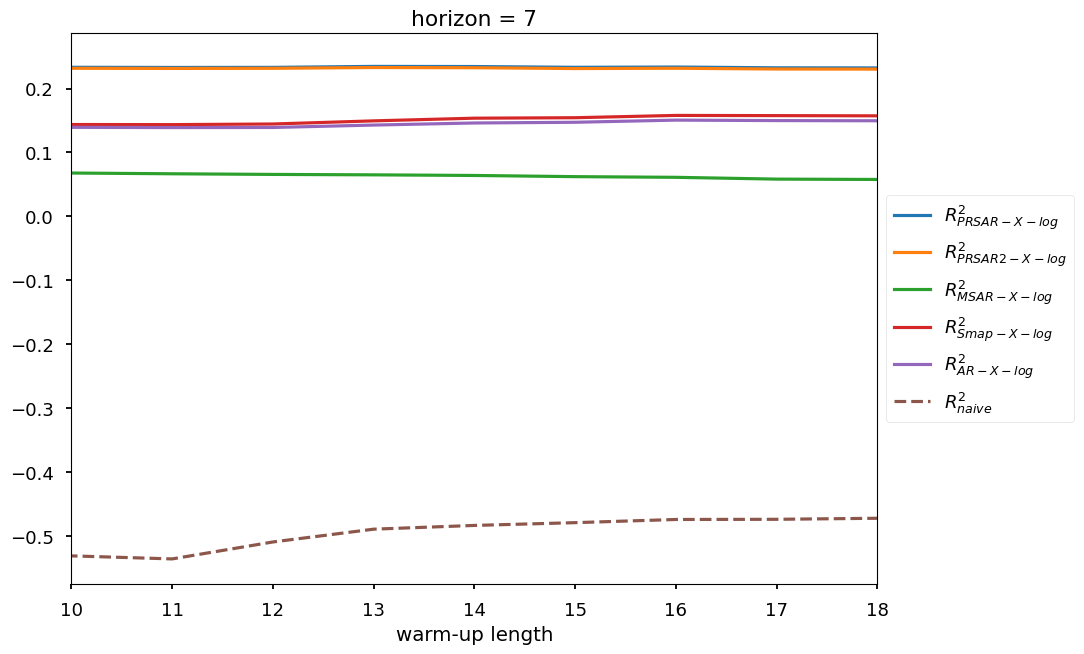

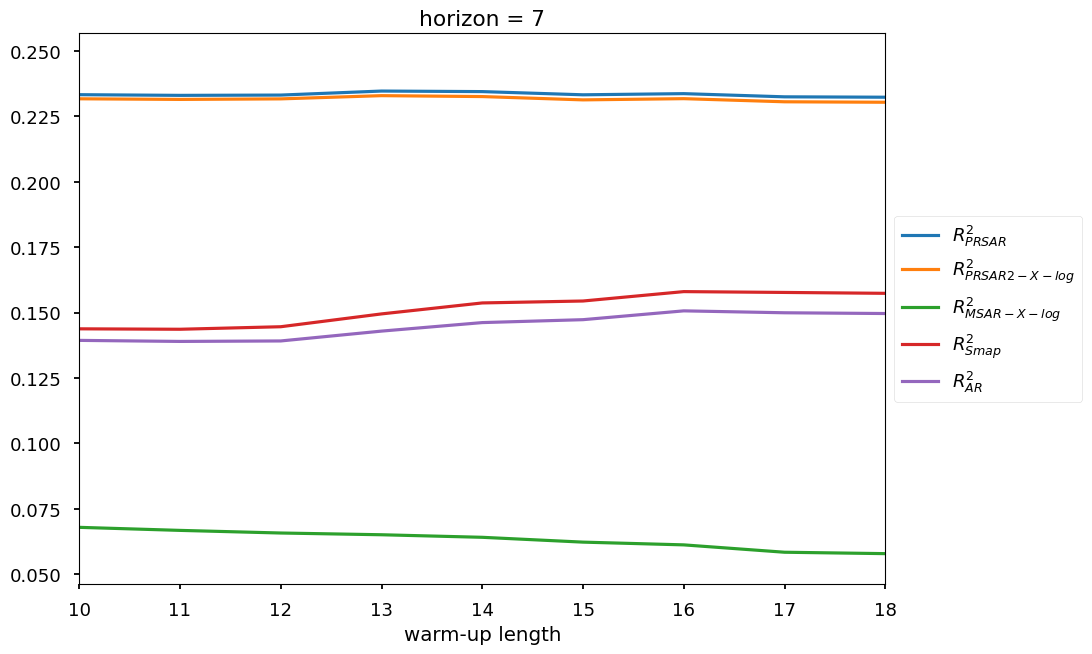

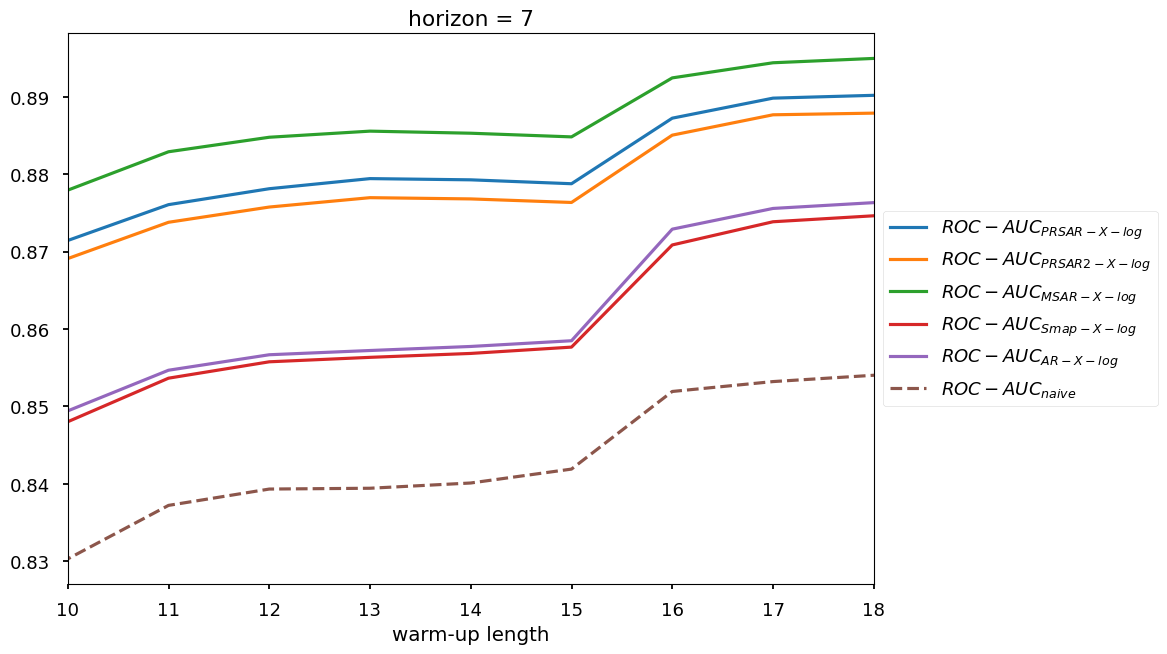

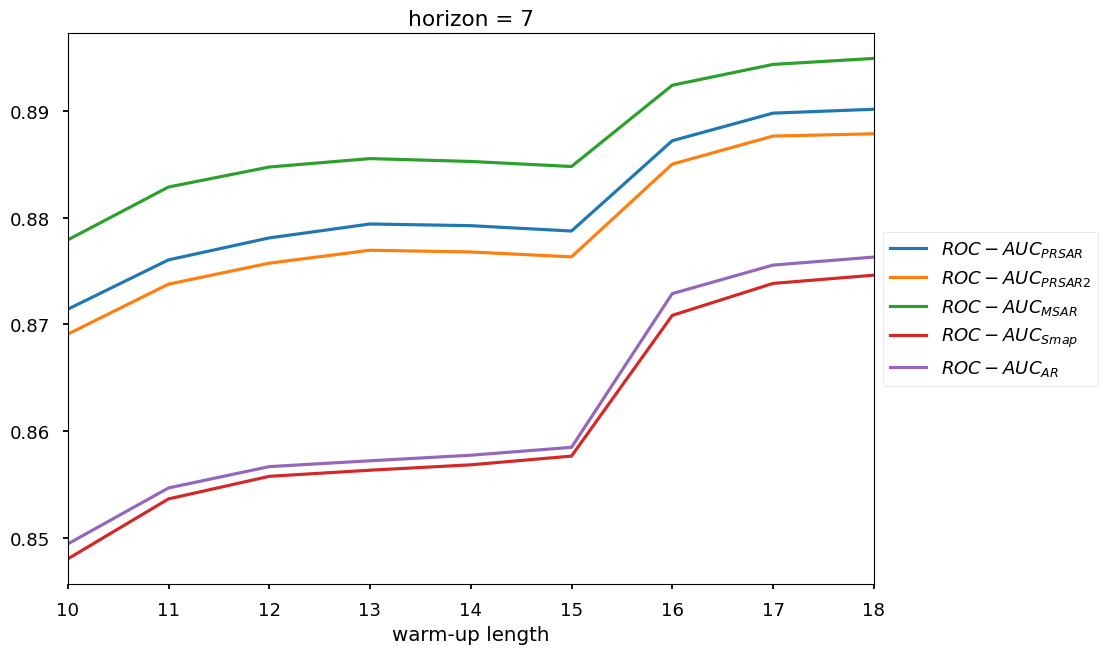

In [28]:

n_seq_warmup = 4
is_phase = True
horizon_forecast = 7

# Data reading
df_pred_eval = df_pred_eval_bak[(df_pred_eval_bak["n_seq_warmup"] == n_seq_warmup) & 
                                (df_pred_eval_bak["is_phase"] == is_phase) &
                                (df_pred_eval_bak["horizon_forecast"] == horizon_forecast)]

list_x, list_r2_naive, list_rocauc_naive = [], [], []
list_r2_ar_log, list_rocauc_ar_log, list_r2_ar, list_rocauc_ar, list_r2_arx_log, list_rocauc_arx_log, list_r2_arx, list_rocauc_arx = [], [], [], [], [], [], [], []
list_r2_smap_log, list_rocauc_smap_log, list_r2_smap, list_rocauc_smap, list_r2_smapx_log, list_rocauc_smapx_log, list_r2_smapx, list_rocauc_smapx = [], [], [], [], [], [], [], []
list_r2_mslr_log, list_rocauc_mslr_log, list_r2_mslr, list_rocauc_mslr, list_r2_mslrx_log, list_rocauc_mslrx_log, list_r2_mslrx, list_rocauc_mslrx = [], [], [], [], [], [], [], []
list_r2_prslr1_log, list_rocauc_prslr1_log, list_r2_prslr1, list_rocauc_prslr1, list_r2_prslr1x_log, list_rocauc_prslr1x_log, list_r2_prslr1x, list_rocauc_prslr1x = [], [], [], [], [], [], [], []
list_r2_prslr2_log, list_rocauc_prslr2_log, list_r2_prslr2, list_rocauc_prslr2, list_r2_prslr2x_log, list_rocauc_prslr2x_log, list_r2_prslr2x, list_rocauc_prslr2x = [], [], [], [], [], [], [], []

for tmp_len_warmup in range(7, 20):
    
    tmp_df_pred_eval = df_pred_eval[df_pred_eval["len_warmup"] == tmp_len_warmup]
    
    tmp_r2_naive, tmp_rocauc_naive = tmp_df_pred_eval["r2_naive"].iloc[0], tmp_df_pred_eval["rocauc_naive"].iloc[0]
    
    tmp_df_pred_eval_ar_log = tmp_df_pred_eval[(tmp_df_pred_eval["is_cross"] == False) & (tmp_df_pred_eval["reg_method"] == "LinearRegression") & (tmp_df_pred_eval["is_log10"] == True)]
    tmp_r2_ar_log, tmp_rocauc_ar_log = tmp_df_pred_eval_ar_log["r2_ar"].iloc[0], tmp_df_pred_eval_ar_log["rocauc_ar"].iloc[0]
    tmp_r2_smap_log, tmp_rocauc_smap_log = tmp_df_pred_eval_ar_log["r2_smap"].iloc[0], tmp_df_pred_eval_ar_log["rocauc_smap"].iloc[0]
    tmp_r2_mslr_log, tmp_rocauc_mslr_log = tmp_df_pred_eval_ar_log["r2_mslr"].iloc[0], tmp_df_pred_eval_ar_log["rocauc_mslr"].iloc[0]
    tmp_r2_prslr1_log, tmp_rocauc_prslr1_log = tmp_df_pred_eval_ar_log["r2_mslrx"].iloc[0], tmp_df_pred_eval_ar_log["rocauc_mslrx"].iloc[0]
    tmp_r2_prslr2_log, tmp_rocauc_prslr2_log = tmp_df_pred_eval_ar_log["r2_mslrxsolu3"].iloc[0], tmp_df_pred_eval_ar_log["rocauc_mslrxsolu3"].iloc[0]
    
    tmp_df_pred_eval_ar = tmp_df_pred_eval[(tmp_df_pred_eval["is_cross"] == False) & (tmp_df_pred_eval["reg_method"] == "LinearRegression") & (tmp_df_pred_eval["is_log10"] == False)]
    tmp_r2_ar, tmp_rocauc_ar = tmp_df_pred_eval_ar["r2_ar"].iloc[0], tmp_df_pred_eval_ar["rocauc_ar"].iloc[0]
    tmp_r2_smap, tmp_rocauc_smap = tmp_df_pred_eval_ar["r2_smap"].iloc[0], tmp_df_pred_eval_ar["rocauc_smap"].iloc[0]
    tmp_r2_mslr, tmp_rocauc_mslr = tmp_df_pred_eval_ar["r2_mslr"].iloc[0], tmp_df_pred_eval_ar["rocauc_mslr"].iloc[0]
    tmp_r2_prslr1, tmp_rocauc_prslr1 = tmp_df_pred_eval_ar["r2_mslrx"].iloc[0], tmp_df_pred_eval_ar["rocauc_mslrx"].iloc[0]
    tmp_r2_prslr2, tmp_rocauc_prslr2 = tmp_df_pred_eval_ar["r2_mslrxsolu3"].iloc[0], tmp_df_pred_eval_ar["rocauc_mslrxsolu3"].iloc[0]
    
    tmp_df_pred_eval_arx_log = tmp_df_pred_eval[(tmp_df_pred_eval["is_cross"] == True) & (tmp_df_pred_eval["reg_method"] == "LinearRegression") & (tmp_df_pred_eval["is_log10"] == True)]
    tmp_r2_arx_log, tmp_rocauc_arx_log = tmp_df_pred_eval_arx_log["r2_ar"].iloc[0], tmp_df_pred_eval_arx_log["rocauc_ar"].iloc[0]
    tmp_r2_smapx_log, tmp_rocauc_smapx_log = tmp_df_pred_eval_arx_log["r2_smap"].iloc[0], tmp_df_pred_eval_arx_log["rocauc_smap"].iloc[0]
    tmp_r2_mslrx_log, tmp_rocauc_mslrx_log = tmp_df_pred_eval_arx_log["r2_mslr"].iloc[0], tmp_df_pred_eval_arx_log["rocauc_mslr"].iloc[0]
    tmp_r2_prslr1x_log, tmp_rocauc_prslr1x_log = tmp_df_pred_eval_arx_log["r2_mslrx"].iloc[0], tmp_df_pred_eval_arx_log["rocauc_mslrx"].iloc[0]
    tmp_r2_prslr2x_log, tmp_rocauc_prslr2x_log = tmp_df_pred_eval_arx_log["r2_mslrxsolu3"].iloc[0], tmp_df_pred_eval_arx_log["rocauc_mslrxsolu3"].iloc[0]
    
    tmp_df_pred_eval_arx = tmp_df_pred_eval[(tmp_df_pred_eval["is_cross"] == True) & (tmp_df_pred_eval["reg_method"] == "LinearRegression") & (tmp_df_pred_eval["is_log10"] == False)]
    tmp_r2_arx, tmp_rocauc_arx = tmp_df_pred_eval_arx["r2_ar"].iloc[0], tmp_df_pred_eval_arx["rocauc_ar"].iloc[0]
    tmp_r2_smapx, tmp_rocauc_smapx = tmp_df_pred_eval_arx["r2_smap"].iloc[0], tmp_df_pred_eval_arx["rocauc_smap"].iloc[0]
    tmp_r2_mslrx, tmp_rocauc_mslrx = tmp_df_pred_eval_arx["r2_mslr"].iloc[0], tmp_df_pred_eval_arx["rocauc_mslr"].iloc[0]
    tmp_r2_prslr1x, tmp_rocauc_prslr1x = tmp_df_pred_eval_arx["r2_mslrx"].iloc[0], tmp_df_pred_eval_arx["rocauc_mslrx"].iloc[0]
    tmp_r2_prslr2x, tmp_rocauc_prslr2x = tmp_df_pred_eval_arx["r2_mslrxsolu3"].iloc[0], tmp_df_pred_eval_arx["rocauc_mslrxsolu3"].iloc[0]
    
    list_x.append(tmp_len_warmup)
    list_r2_naive.append(tmp_r2_naive)
    list_rocauc_naive.append(tmp_rocauc_naive)
    
    list_r2_ar_log.append(tmp_r2_ar_log)
    list_rocauc_ar_log.append(tmp_rocauc_ar_log)
    list_r2_ar.append(tmp_r2_ar)
    list_rocauc_ar.append(tmp_rocauc_ar)
    list_r2_arx_log.append(tmp_r2_arx_log)
    list_rocauc_arx_log.append(tmp_rocauc_arx_log)
    list_r2_arx.append(tmp_r2_arx)
    list_rocauc_arx.append(tmp_rocauc_arx)
    
    list_r2_smap_log.append(tmp_r2_smap_log)
    list_rocauc_smap_log.append(tmp_rocauc_smap_log)
    list_r2_smap.append(tmp_r2_smap)
    list_rocauc_smap.append(tmp_rocauc_smap)
    list_r2_smapx_log.append(tmp_r2_smapx_log)
    list_rocauc_smapx_log.append(tmp_rocauc_smapx_log)
    list_r2_smapx.append(tmp_r2_smapx)
    list_rocauc_smapx.append(tmp_rocauc_smapx)
    
    list_r2_mslr_log.append(tmp_r2_mslr_log)
    list_rocauc_mslr_log.append(tmp_rocauc_mslr_log)
    list_r2_mslr.append(tmp_r2_mslr)
    list_rocauc_mslr.append(tmp_rocauc_mslr)
    list_r2_mslrx_log.append(tmp_r2_mslrx_log)
    list_rocauc_mslrx_log.append(tmp_rocauc_mslrx_log)
    list_r2_mslrx.append(tmp_r2_mslrx)
    list_rocauc_mslrx.append(tmp_rocauc_mslrx)
    
    list_r2_prslr1_log.append(tmp_r2_prslr1_log)
    list_rocauc_prslr1_log.append(tmp_rocauc_prslr1_log)
    list_r2_prslr1.append(tmp_r2_prslr1)
    list_rocauc_prslr1.append(tmp_rocauc_prslr1)
    list_r2_prslr1x_log.append(tmp_r2_prslr1x_log)
    list_rocauc_prslr1x_log.append(tmp_rocauc_prslr1x_log)
    list_r2_prslr1x.append(tmp_r2_prslr1x)
    list_rocauc_prslr1x.append(tmp_rocauc_prslr1x)
    
    list_r2_prslr2_log.append(tmp_r2_prslr2_log)
    list_rocauc_prslr2_log.append(tmp_rocauc_prslr2_log)
    list_r2_prslr2.append(tmp_r2_prslr2)
    list_rocauc_prslr2.append(tmp_rocauc_prslr2)
    list_r2_prslr2x_log.append(tmp_r2_prslr2x_log)
    list_rocauc_prslr2x_log.append(tmp_rocauc_prslr2x_log)
    list_r2_prslr2x.append(tmp_r2_prslr2x)
    list_rocauc_prslr2x.append(tmp_rocauc_prslr2x)

# R2 plot
# plt.plot(list_x, list_r2_prslr1_log, label = r'$R^2_{PRSAR1-log}$')
# plt.plot(list_x, list_r2_prslr1, label = r'$R^2_{PRSAR1}$')
plt.plot(list_x, list_r2_prslr1x_log, label = r'$R^2_{PRSAR-X-log}$')
# plt.plot(list_x, list_r2_prslr1x, label = r'$R^2_{PRSAR1-X}$')

# plt.plot(list_x, list_r2_prslr2_log, label = r'$R^2_{PRSAR2-log}$')
# plt.plot(list_x, list_r2_prslr2, label = r'$R^2_{PRSAR2}$')
plt.plot(list_x, list_r2_prslr2x_log, label = r'$R^2_{PRSAR2-X-log}$')
# plt.plot(list_x, list_r2_prslr2x, label = r'$R^2_{PRSAR2-X}$')

# plt.plot(list_x, list_r2_mslr_log, label = r'$R^2_{MSAR-log}$')
# plt.plot(list_x, list_r2_mslr, label = r'$R^2_{MSAR}$')
plt.plot(list_x, list_r2_mslrx_log, label = r'$R^2_{MSAR-X-log}$')
# plt.plot(list_x, list_r2_mslrx, label = r'$R^2_{MSAR-X}$')

# plt.plot(list_x, list_r2_smap_log, label = r'$R^2_{Smap-log}$')
# plt.plot(list_x, list_r2_smap, label = r'$R^2_{Smap}$')
plt.plot(list_x, list_r2_smapx_log, label = r'$R^2_{Smap-X-log}$')
# plt.plot(list_x, list_r2_smapx, label = r'$R^2_{Smap-X}$')

# plt.plot(list_x, list_r2_ar_log, label = r'$R^2_{AR-log}$')
# plt.plot(list_x, list_r2_ar, label = r'$R^2_{AR}$')
plt.plot(list_x, list_r2_arx_log, label = r'$R^2_{AR-X-log}$')
# plt.plot(list_x, list_r2_arx, label = r'$R^2_{AR-X}$')

plt.plot(list_x, list_r2_naive, "--", label = r'$R^2_{naive}$')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(10, 18)
#plt.ylim(0, 0.4)
plt.xlabel("warm-up length")
plt.title("horizon = % s" % horizon_forecast)
plt.show()

# R2 plot
plt.plot(list_x, list_r2_prslr1x_log, label = r'$R^2_{PRSAR}$')
plt.plot(list_x, list_r2_prslr2x_log, label = r'$R^2_{PRSAR2-X-log}$')
plt.plot(list_x, list_r2_mslrx_log, label = r'$R^2_{MSAR-X-log}$')
plt.plot(list_x, list_r2_smapx_log, label = r'$R^2_{Smap}$')
plt.plot(list_x, list_r2_arx_log, label = r'$R^2_{AR}$')
#plt.plot(list_x, list_r2_naive, "--", label = r'$R^2_{naive}$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(10, 18)
#plt.ylim(0, 0.4)
plt.xlabel("warm-up length")
plt.title("horizon = % s" % horizon_forecast)
plt.show()

# ROC-AUC plot
# plt.plot(list_x, list_rocauc_prslr1_log, label = r'$ROC-AUC_{PRSAR1-log}$')
# plt.plot(list_x, list_rocauc_prslr1, label = r'$ROC-AUC_{PRSAR1}$')
plt.plot(list_x, list_rocauc_prslr1x_log, label = r'$ROC-AUC_{PRSAR-X-log}$')
# plt.plot(list_x, list_rocauc_prslr1x, label = r'$ROC-AUC_{PRSAR1-X}$')

# plt.plot(list_x, list_rocauc_prslr2_log, label = r'$ROC-AUC_{PRSAR2-log}$')
# plt.plot(list_x, list_rocauc_prslr2, label = r'$ROC-AUC_{PRSAR2}$')
plt.plot(list_x, list_rocauc_prslr2x_log, label = r'$ROC-AUC_{PRSAR2-X-log}$')
# plt.plot(list_x, list_rocauc_prslr2x, label = r'$ROC-AUC_{PRSAR2-X}$')

# plt.plot(list_x, list_rocauc_mslr_log, label = r'$ROC-AUC_{MSAR-log}$')
# plt.plot(list_x, list_rocauc_mslr, label = r'$ROC-AUC_{MSAR}$')
plt.plot(list_x, list_rocauc_mslrx_log, label = r'$ROC-AUC_{MSAR-X-log}$')
# plt.plot(list_x, list_rocauc_mslrx, label = r'$ROC-AUC_{MSAR-X}$')

# plt.plot(list_x, list_rocauc_smap_log, label = r'$ROC-AUC_{Smap-log}$')
# plt.plot(list_x, list_rocauc_smap, label = r'$ROC-AUC_{Smap}$')
plt.plot(list_x, list_rocauc_smapx_log, label = r'$ROC-AUC_{Smap-X-log}$')
# plt.plot(list_x, list_rocauc_smapx, label = r'$ROC-AUC_{Smap-X}$')

# plt.plot(list_x, list_rocauc_ar_log, label = r'$ROC-AUC_{AR-log}$')
# plt.plot(list_x, list_rocauc_ar, label = r'$ROC-AUC_{AR}$')
plt.plot(list_x, list_rocauc_arx_log, label = r'$ROC-AUC_{AR-X-log}$')
# plt.plot(list_x, list_rocauc_arx, label = r'$ROC-AUC_{AR-X}$')

plt.plot(list_x, list_rocauc_naive, "--", label = r'$ROC-AUC_{naive}$')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(10, 18)
#plt.ylim(0, 0.4)
plt.xlabel("warm-up length")
plt.title("horizon = % s" % horizon_forecast)
plt.show()

# ROC-AUC plot
plt.plot(list_x, list_rocauc_prslr1x_log, label = r'$ROC-AUC_{PRSAR}$')
plt.plot(list_x, list_rocauc_prslr2x_log, label = r'$ROC-AUC_{PRSAR2}$')
plt.plot(list_x, list_rocauc_mslrx_log, label = r'$ROC-AUC_{MSAR}$')
plt.plot(list_x, list_rocauc_smapx_log, label = r'$ROC-AUC_{Smap}$')
plt.plot(list_x, list_rocauc_arx_log, label = r'$ROC-AUC_{AR}$')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(10, 18)
plt.xlabel("warm-up length")
plt.title("horizon = % s" % horizon_forecast)
plt.show()


#### Compare: wind vs no wind on WW

In [46]:
df_pred_eval_wind = pd.read_csv(r"res/res_vimsww_wind_pred_0207_2.csv")
df_pred_eval_wind["is_wind"] = True

df_pred_eval_nowind = pd.read_csv(r"res/res_vimsww_nowind_pred_0207_2.csv")
df_pred_eval_nowind["is_wind"] = False

df_pred_eval = pd.concat([df_pred_eval_wind, df_pred_eval_nowind])

df_pred_eval = df_pred_eval.rename(columns = {"tmp_r2_mslrxsolu3": "r2_mslrxsolu3", "tmp_rocauc_mslrxsolu3": "rocauc_mslrxsolu3", "tmp_r2_mslr": "r2_mslr", "tmp_rocauc_mslr": "rocauc_mslr", })
df_pred_eval_bak = df_pred_eval

df_pred_eval_bak.head()


,is_log10,is_cross,is_phase,horizon_forecast,reg_method,n_seq_warmup,len_warmup,r2_naive,rocauc_naive,r2_ar,rocauc_ar,r2_smap,rocauc_smap,r2_mslrx,rocauc_mslrx,r2_mslrxsolu3,rocauc_mslrxsolu3,r2_mslr,rocauc_mslr,is_wind
0,True,True,True,1,LinearRegression,1,7,0.633636,0.969722,0.685345,0.968879,0.690383,0.969188,0.663975,0.969615,0.666227,0.969283,0.686720,0.969401,True
1,True,True,True,1,LinearRegression,1,8,0.633354,0.969762,0.691097,0.969054,0.695733,0.969307,0.668015,0.969813,0.670571,0.969484,0.692144,0.969585,True
2,True,True,True,1,LinearRegression,1,9,0.626579,0.969241,0.685438,0.968740,0.689848,0.969004,0.660424,0.969373,0.662519,0.968951,0.686150,0.969294,True
3,True,True,True,1,LinearRegression,1,10,0.631897,0.970090,0.689381,0.969634,0.694033,0.969875,0.663782,0.970197,0.666120,0.969741,0.689711,0.970117,True
4,True,True,True,1,LinearRegression,1,11,0.627127,0.970055,0.686323,0.970155,0.691104,0.970529,0.660734,0.971392,0.663451,0.970903,0.686806,0.970903,True


In [57]:
n_seq_warmup = 4
is_phase = True
horizon_forecast = 7

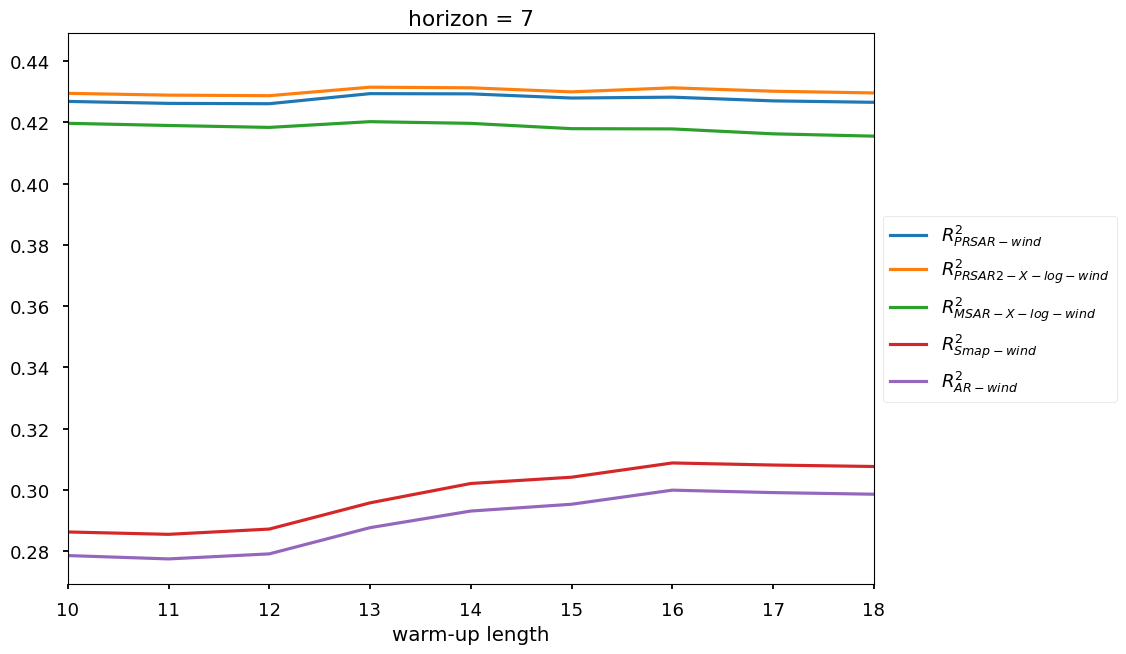

In [58]:

for is_wind in [True, ]:
    df_pred_eval = df_pred_eval_bak[(df_pred_eval_bak["n_seq_warmup"] == n_seq_warmup) & 
                                    (df_pred_eval_bak["is_phase"] == is_phase) &
                                    (df_pred_eval_bak["horizon_forecast"] == horizon_forecast) &
                                    (df_pred_eval_bak["is_wind"] == is_wind)]

    list_x, list_r2_naive, list_rocauc_naive = [], [], []
    list_r2_ar_log, list_rocauc_ar_log, list_r2_ar, list_rocauc_ar, list_r2_arx_log, list_rocauc_arx_log, list_r2_arx, list_rocauc_arx = [], [], [], [], [], [], [], []
    list_r2_smap_log, list_rocauc_smap_log, list_r2_smap, list_rocauc_smap, list_r2_smapx_log, list_rocauc_smapx_log, list_r2_smapx, list_rocauc_smapx = [], [], [], [], [], [], [], []
    list_r2_mslr_log, list_rocauc_mslr_log, list_r2_mslr, list_rocauc_mslr, list_r2_mslrx_log, list_rocauc_mslrx_log, list_r2_mslrx, list_rocauc_mslrx = [], [], [], [], [], [], [], []
    list_r2_prslr1_log, list_rocauc_prslr1_log, list_r2_prslr1, list_rocauc_prslr1, list_r2_prslr1x_log, list_rocauc_prslr1x_log, list_r2_prslr1x, list_rocauc_prslr1x = [], [], [], [], [], [], [], []
    list_r2_prslr2_log, list_rocauc_prslr2_log, list_r2_prslr2, list_rocauc_prslr2, list_r2_prslr2x_log, list_rocauc_prslr2x_log, list_r2_prslr2x, list_rocauc_prslr2x = [], [], [], [], [], [], [], []

    for tmp_len_warmup in range(7, 20):

        tmp_df_pred_eval = df_pred_eval[df_pred_eval["len_warmup"] == tmp_len_warmup]

        tmp_r2_naive, tmp_rocauc_naive = tmp_df_pred_eval["r2_naive"].iloc[0], tmp_df_pred_eval["rocauc_naive"].iloc[0]

        tmp_df_pred_eval_ar_log = tmp_df_pred_eval[(tmp_df_pred_eval["is_cross"] == False) & (tmp_df_pred_eval["reg_method"] == "LinearRegression") & (tmp_df_pred_eval["is_log10"] == True)]
        tmp_r2_ar_log, tmp_rocauc_ar_log = tmp_df_pred_eval_ar_log["r2_ar"].iloc[0], tmp_df_pred_eval_ar_log["rocauc_ar"].iloc[0]
        tmp_r2_smap_log, tmp_rocauc_smap_log = tmp_df_pred_eval_ar_log["r2_smap"].iloc[0], tmp_df_pred_eval_ar_log["rocauc_smap"].iloc[0]
        tmp_r2_mslr_log, tmp_rocauc_mslr_log = tmp_df_pred_eval_ar_log["r2_mslr"].iloc[0], tmp_df_pred_eval_ar_log["rocauc_mslr"].iloc[0]
        tmp_r2_prslr1_log, tmp_rocauc_prslr1_log = tmp_df_pred_eval_ar_log["r2_mslrx"].iloc[0], tmp_df_pred_eval_ar_log["rocauc_mslrx"].iloc[0]
        tmp_r2_prslr2_log, tmp_rocauc_prslr2_log = tmp_df_pred_eval_ar_log["r2_mslrxsolu3"].iloc[0], tmp_df_pred_eval_ar_log["rocauc_mslrxsolu3"].iloc[0]

        tmp_df_pred_eval_ar = tmp_df_pred_eval[(tmp_df_pred_eval["is_cross"] == False) & (tmp_df_pred_eval["reg_method"] == "LinearRegression") & (tmp_df_pred_eval["is_log10"] == False)]
        tmp_r2_ar, tmp_rocauc_ar = tmp_df_pred_eval_ar["r2_ar"].iloc[0], tmp_df_pred_eval_ar["rocauc_ar"].iloc[0]
        tmp_r2_smap, tmp_rocauc_smap = tmp_df_pred_eval_ar["r2_smap"].iloc[0], tmp_df_pred_eval_ar["rocauc_smap"].iloc[0]
        tmp_r2_mslr, tmp_rocauc_mslr = tmp_df_pred_eval_ar["r2_mslr"].iloc[0], tmp_df_pred_eval_ar["rocauc_mslr"].iloc[0]
        tmp_r2_prslr1, tmp_rocauc_prslr1 = tmp_df_pred_eval_ar["r2_mslrx"].iloc[0], tmp_df_pred_eval_ar["rocauc_mslrx"].iloc[0]
        tmp_r2_prslr2, tmp_rocauc_prslr2 = tmp_df_pred_eval_ar["r2_mslrxsolu3"].iloc[0], tmp_df_pred_eval_ar["rocauc_mslrxsolu3"].iloc[0]

        tmp_df_pred_eval_arx_log = tmp_df_pred_eval[(tmp_df_pred_eval["is_cross"] == True) & (tmp_df_pred_eval["reg_method"] == "LinearRegression") & (tmp_df_pred_eval["is_log10"] == True)]
        tmp_r2_arx_log, tmp_rocauc_arx_log = tmp_df_pred_eval_arx_log["r2_ar"].iloc[0], tmp_df_pred_eval_arx_log["rocauc_ar"].iloc[0]
        tmp_r2_smapx_log, tmp_rocauc_smapx_log = tmp_df_pred_eval_arx_log["r2_smap"].iloc[0], tmp_df_pred_eval_arx_log["rocauc_smap"].iloc[0]
        tmp_r2_mslrx_log, tmp_rocauc_mslrx_log = tmp_df_pred_eval_arx_log["r2_mslr"].iloc[0], tmp_df_pred_eval_arx_log["rocauc_mslr"].iloc[0]
        tmp_r2_prslr1x_log, tmp_rocauc_prslr1x_log = tmp_df_pred_eval_arx_log["r2_mslrx"].iloc[0], tmp_df_pred_eval_arx_log["rocauc_mslrx"].iloc[0]
        tmp_r2_prslr2x_log, tmp_rocauc_prslr2x_log = tmp_df_pred_eval_arx_log["r2_mslrxsolu3"].iloc[0], tmp_df_pred_eval_arx_log["rocauc_mslrxsolu3"].iloc[0]

        tmp_df_pred_eval_arx = tmp_df_pred_eval[(tmp_df_pred_eval["is_cross"] == True) & (tmp_df_pred_eval["reg_method"] == "LinearRegression") & (tmp_df_pred_eval["is_log10"] == False)]
        tmp_r2_arx, tmp_rocauc_arx = tmp_df_pred_eval_arx["r2_ar"].iloc[0], tmp_df_pred_eval_arx["rocauc_ar"].iloc[0]
        tmp_r2_smapx, tmp_rocauc_smapx = tmp_df_pred_eval_arx["r2_smap"].iloc[0], tmp_df_pred_eval_arx["rocauc_smap"].iloc[0]
        tmp_r2_mslrx, tmp_rocauc_mslrx = tmp_df_pred_eval_arx["r2_mslr"].iloc[0], tmp_df_pred_eval_arx["rocauc_mslr"].iloc[0]
        tmp_r2_prslr1x, tmp_rocauc_prslr1x = tmp_df_pred_eval_arx["r2_mslrx"].iloc[0], tmp_df_pred_eval_arx["rocauc_mslrx"].iloc[0]
        tmp_r2_prslr2x, tmp_rocauc_prslr2x = tmp_df_pred_eval_arx["r2_mslrxsolu3"].iloc[0], tmp_df_pred_eval_arx["rocauc_mslrxsolu3"].iloc[0]

        list_x.append(tmp_len_warmup)
        list_r2_naive.append(tmp_r2_naive)
        list_rocauc_naive.append(tmp_rocauc_naive)

        list_r2_ar_log.append(tmp_r2_ar_log)
        list_rocauc_ar_log.append(tmp_rocauc_ar_log)
        list_r2_ar.append(tmp_r2_ar)
        list_rocauc_ar.append(tmp_rocauc_ar)
        list_r2_arx_log.append(tmp_r2_arx_log)
        list_rocauc_arx_log.append(tmp_rocauc_arx_log)
        list_r2_arx.append(tmp_r2_arx)
        list_rocauc_arx.append(tmp_rocauc_arx)

        list_r2_smap_log.append(tmp_r2_smap_log)
        list_rocauc_smap_log.append(tmp_rocauc_smap_log)
        list_r2_smap.append(tmp_r2_smap)
        list_rocauc_smap.append(tmp_rocauc_smap)
        list_r2_smapx_log.append(tmp_r2_smapx_log)
        list_rocauc_smapx_log.append(tmp_rocauc_smapx_log)
        list_r2_smapx.append(tmp_r2_smapx)
        list_rocauc_smapx.append(tmp_rocauc_smapx)

        list_r2_mslr_log.append(tmp_r2_mslr_log)
        list_rocauc_mslr_log.append(tmp_rocauc_mslr_log)
        list_r2_mslr.append(tmp_r2_mslr)
        list_rocauc_mslr.append(tmp_rocauc_mslr)
        list_r2_mslrx_log.append(tmp_r2_mslrx_log)
        list_rocauc_mslrx_log.append(tmp_rocauc_mslrx_log)
        list_r2_mslrx.append(tmp_r2_mslrx)
        list_rocauc_mslrx.append(tmp_rocauc_mslrx)

        list_r2_prslr1_log.append(tmp_r2_prslr1_log)
        list_rocauc_prslr1_log.append(tmp_rocauc_prslr1_log)
        list_r2_prslr1.append(tmp_r2_prslr1)
        list_rocauc_prslr1.append(tmp_rocauc_prslr1)
        list_r2_prslr1x_log.append(tmp_r2_prslr1x_log)
        list_rocauc_prslr1x_log.append(tmp_rocauc_prslr1x_log)
        list_r2_prslr1x.append(tmp_r2_prslr1x)
        list_rocauc_prslr1x.append(tmp_rocauc_prslr1x)

        list_r2_prslr2_log.append(tmp_r2_prslr2_log)
        list_rocauc_prslr2_log.append(tmp_rocauc_prslr2_log)
        list_r2_prslr2.append(tmp_r2_prslr2)
        list_rocauc_prslr2.append(tmp_rocauc_prslr2)
        list_r2_prslr2x_log.append(tmp_r2_prslr2x_log)
        list_rocauc_prslr2x_log.append(tmp_rocauc_prslr2x_log)
        list_r2_prslr2x.append(tmp_r2_prslr2x)
        list_rocauc_prslr2x.append(tmp_rocauc_prslr2x)

    # R2 plot
    
    tail = "-wind" if is_wind else ""
    
    plt.plot(list_x, list_r2_prslr1x_log, label = r'$R^2_{PRSAR% s}$' % tail)
    plt.plot(list_x, list_r2_prslr2x_log, label = r'$R^2_{PRSAR2-X-log% s}$' % tail)
    plt.plot(list_x, list_r2_mslrx_log, label = r'$R^2_{MSAR-X-log% s}$' % tail)
    plt.plot(list_x, list_r2_smapx_log, label = r'$R^2_{Smap% s}$' % tail)
    plt.plot(list_x, list_r2_arx_log, label = r'$R^2_{AR% s}$' % tail)
    #plt.plot(list_x, list_r2_naive, "--", label = r'$R^2_{naive}$')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(10, 18)
#plt.ylim(0, 0.4)
plt.xlabel("warm-up length")
plt.title("horizon = % s" % horizon_forecast)
plt.show()

    


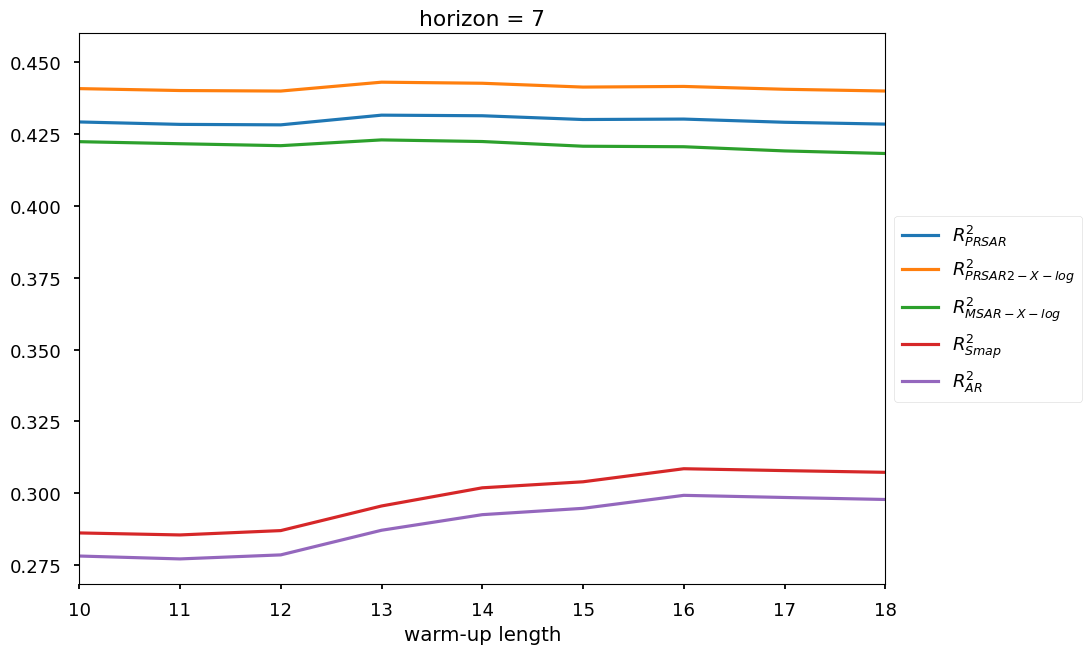

In [59]:

for is_wind in [False, ]:
    df_pred_eval = df_pred_eval_bak[(df_pred_eval_bak["n_seq_warmup"] == n_seq_warmup) & 
                                    (df_pred_eval_bak["is_phase"] == is_phase) &
                                    (df_pred_eval_bak["horizon_forecast"] == horizon_forecast) &
                                    (df_pred_eval_bak["is_wind"] == is_wind)]

    list_x, list_r2_naive, list_rocauc_naive = [], [], []
    list_r2_ar_log, list_rocauc_ar_log, list_r2_ar, list_rocauc_ar, list_r2_arx_log, list_rocauc_arx_log, list_r2_arx, list_rocauc_arx = [], [], [], [], [], [], [], []
    list_r2_smap_log, list_rocauc_smap_log, list_r2_smap, list_rocauc_smap, list_r2_smapx_log, list_rocauc_smapx_log, list_r2_smapx, list_rocauc_smapx = [], [], [], [], [], [], [], []
    list_r2_mslr_log, list_rocauc_mslr_log, list_r2_mslr, list_rocauc_mslr, list_r2_mslrx_log, list_rocauc_mslrx_log, list_r2_mslrx, list_rocauc_mslrx = [], [], [], [], [], [], [], []
    list_r2_prslr1_log, list_rocauc_prslr1_log, list_r2_prslr1, list_rocauc_prslr1, list_r2_prslr1x_log, list_rocauc_prslr1x_log, list_r2_prslr1x, list_rocauc_prslr1x = [], [], [], [], [], [], [], []
    list_r2_prslr2_log, list_rocauc_prslr2_log, list_r2_prslr2, list_rocauc_prslr2, list_r2_prslr2x_log, list_rocauc_prslr2x_log, list_r2_prslr2x, list_rocauc_prslr2x = [], [], [], [], [], [], [], []

    for tmp_len_warmup in range(7, 20):

        tmp_df_pred_eval = df_pred_eval[df_pred_eval["len_warmup"] == tmp_len_warmup]

        tmp_r2_naive, tmp_rocauc_naive = tmp_df_pred_eval["r2_naive"].iloc[0], tmp_df_pred_eval["rocauc_naive"].iloc[0]

        tmp_df_pred_eval_ar_log = tmp_df_pred_eval[(tmp_df_pred_eval["is_cross"] == False) & (tmp_df_pred_eval["reg_method"] == "LinearRegression") & (tmp_df_pred_eval["is_log10"] == True)]
        tmp_r2_ar_log, tmp_rocauc_ar_log = tmp_df_pred_eval_ar_log["r2_ar"].iloc[0], tmp_df_pred_eval_ar_log["rocauc_ar"].iloc[0]
        tmp_r2_smap_log, tmp_rocauc_smap_log = tmp_df_pred_eval_ar_log["r2_smap"].iloc[0], tmp_df_pred_eval_ar_log["rocauc_smap"].iloc[0]
        tmp_r2_mslr_log, tmp_rocauc_mslr_log = tmp_df_pred_eval_ar_log["r2_mslr"].iloc[0], tmp_df_pred_eval_ar_log["rocauc_mslr"].iloc[0]
        tmp_r2_prslr1_log, tmp_rocauc_prslr1_log = tmp_df_pred_eval_ar_log["r2_mslrx"].iloc[0], tmp_df_pred_eval_ar_log["rocauc_mslrx"].iloc[0]
        tmp_r2_prslr2_log, tmp_rocauc_prslr2_log = tmp_df_pred_eval_ar_log["r2_mslrxsolu3"].iloc[0], tmp_df_pred_eval_ar_log["rocauc_mslrxsolu3"].iloc[0]

        tmp_df_pred_eval_ar = tmp_df_pred_eval[(tmp_df_pred_eval["is_cross"] == False) & (tmp_df_pred_eval["reg_method"] == "LinearRegression") & (tmp_df_pred_eval["is_log10"] == False)]
        tmp_r2_ar, tmp_rocauc_ar = tmp_df_pred_eval_ar["r2_ar"].iloc[0], tmp_df_pred_eval_ar["rocauc_ar"].iloc[0]
        tmp_r2_smap, tmp_rocauc_smap = tmp_df_pred_eval_ar["r2_smap"].iloc[0], tmp_df_pred_eval_ar["rocauc_smap"].iloc[0]
        tmp_r2_mslr, tmp_rocauc_mslr = tmp_df_pred_eval_ar["r2_mslr"].iloc[0], tmp_df_pred_eval_ar["rocauc_mslr"].iloc[0]
        tmp_r2_prslr1, tmp_rocauc_prslr1 = tmp_df_pred_eval_ar["r2_mslrx"].iloc[0], tmp_df_pred_eval_ar["rocauc_mslrx"].iloc[0]
        tmp_r2_prslr2, tmp_rocauc_prslr2 = tmp_df_pred_eval_ar["r2_mslrxsolu3"].iloc[0], tmp_df_pred_eval_ar["rocauc_mslrxsolu3"].iloc[0]

        tmp_df_pred_eval_arx_log = tmp_df_pred_eval[(tmp_df_pred_eval["is_cross"] == True) & (tmp_df_pred_eval["reg_method"] == "LinearRegression") & (tmp_df_pred_eval["is_log10"] == True)]
        tmp_r2_arx_log, tmp_rocauc_arx_log = tmp_df_pred_eval_arx_log["r2_ar"].iloc[0], tmp_df_pred_eval_arx_log["rocauc_ar"].iloc[0]
        tmp_r2_smapx_log, tmp_rocauc_smapx_log = tmp_df_pred_eval_arx_log["r2_smap"].iloc[0], tmp_df_pred_eval_arx_log["rocauc_smap"].iloc[0]
        tmp_r2_mslrx_log, tmp_rocauc_mslrx_log = tmp_df_pred_eval_arx_log["r2_mslr"].iloc[0], tmp_df_pred_eval_arx_log["rocauc_mslr"].iloc[0]
        tmp_r2_prslr1x_log, tmp_rocauc_prslr1x_log = tmp_df_pred_eval_arx_log["r2_mslrx"].iloc[0], tmp_df_pred_eval_arx_log["rocauc_mslrx"].iloc[0]
        tmp_r2_prslr2x_log, tmp_rocauc_prslr2x_log = tmp_df_pred_eval_arx_log["r2_mslrxsolu3"].iloc[0], tmp_df_pred_eval_arx_log["rocauc_mslrxsolu3"].iloc[0]

        tmp_df_pred_eval_arx = tmp_df_pred_eval[(tmp_df_pred_eval["is_cross"] == True) & (tmp_df_pred_eval["reg_method"] == "LinearRegression") & (tmp_df_pred_eval["is_log10"] == False)]
        tmp_r2_arx, tmp_rocauc_arx = tmp_df_pred_eval_arx["r2_ar"].iloc[0], tmp_df_pred_eval_arx["rocauc_ar"].iloc[0]
        tmp_r2_smapx, tmp_rocauc_smapx = tmp_df_pred_eval_arx["r2_smap"].iloc[0], tmp_df_pred_eval_arx["rocauc_smap"].iloc[0]
        tmp_r2_mslrx, tmp_rocauc_mslrx = tmp_df_pred_eval_arx["r2_mslr"].iloc[0], tmp_df_pred_eval_arx["rocauc_mslr"].iloc[0]
        tmp_r2_prslr1x, tmp_rocauc_prslr1x = tmp_df_pred_eval_arx["r2_mslrx"].iloc[0], tmp_df_pred_eval_arx["rocauc_mslrx"].iloc[0]
        tmp_r2_prslr2x, tmp_rocauc_prslr2x = tmp_df_pred_eval_arx["r2_mslrxsolu3"].iloc[0], tmp_df_pred_eval_arx["rocauc_mslrxsolu3"].iloc[0]

        list_x.append(tmp_len_warmup)
        list_r2_naive.append(tmp_r2_naive)
        list_rocauc_naive.append(tmp_rocauc_naive)

        list_r2_ar_log.append(tmp_r2_ar_log)
        list_rocauc_ar_log.append(tmp_rocauc_ar_log)
        list_r2_ar.append(tmp_r2_ar)
        list_rocauc_ar.append(tmp_rocauc_ar)
        list_r2_arx_log.append(tmp_r2_arx_log)
        list_rocauc_arx_log.append(tmp_rocauc_arx_log)
        list_r2_arx.append(tmp_r2_arx)
        list_rocauc_arx.append(tmp_rocauc_arx)

        list_r2_smap_log.append(tmp_r2_smap_log)
        list_rocauc_smap_log.append(tmp_rocauc_smap_log)
        list_r2_smap.append(tmp_r2_smap)
        list_rocauc_smap.append(tmp_rocauc_smap)
        list_r2_smapx_log.append(tmp_r2_smapx_log)
        list_rocauc_smapx_log.append(tmp_rocauc_smapx_log)
        list_r2_smapx.append(tmp_r2_smapx)
        list_rocauc_smapx.append(tmp_rocauc_smapx)

        list_r2_mslr_log.append(tmp_r2_mslr_log)
        list_rocauc_mslr_log.append(tmp_rocauc_mslr_log)
        list_r2_mslr.append(tmp_r2_mslr)
        list_rocauc_mslr.append(tmp_rocauc_mslr)
        list_r2_mslrx_log.append(tmp_r2_mslrx_log)
        list_rocauc_mslrx_log.append(tmp_rocauc_mslrx_log)
        list_r2_mslrx.append(tmp_r2_mslrx)
        list_rocauc_mslrx.append(tmp_rocauc_mslrx)

        list_r2_prslr1_log.append(tmp_r2_prslr1_log)
        list_rocauc_prslr1_log.append(tmp_rocauc_prslr1_log)
        list_r2_prslr1.append(tmp_r2_prslr1)
        list_rocauc_prslr1.append(tmp_rocauc_prslr1)
        list_r2_prslr1x_log.append(tmp_r2_prslr1x_log)
        list_rocauc_prslr1x_log.append(tmp_rocauc_prslr1x_log)
        list_r2_prslr1x.append(tmp_r2_prslr1x)
        list_rocauc_prslr1x.append(tmp_rocauc_prslr1x)

        list_r2_prslr2_log.append(tmp_r2_prslr2_log)
        list_rocauc_prslr2_log.append(tmp_rocauc_prslr2_log)
        list_r2_prslr2.append(tmp_r2_prslr2)
        list_rocauc_prslr2.append(tmp_rocauc_prslr2)
        list_r2_prslr2x_log.append(tmp_r2_prslr2x_log)
        list_rocauc_prslr2x_log.append(tmp_rocauc_prslr2x_log)
        list_r2_prslr2x.append(tmp_r2_prslr2x)
        list_rocauc_prslr2x.append(tmp_rocauc_prslr2x)

    # R2 plot
    
    tail = "-wind" if is_wind else ""
    
    plt.plot(list_x, list_r2_prslr1x_log, label = r'$R^2_{PRSAR% s}$' % tail)
    plt.plot(list_x, list_r2_prslr2x_log, label = r'$R^2_{PRSAR2-X-log% s}$' % tail)
    plt.plot(list_x, list_r2_mslrx_log, label = r'$R^2_{MSAR-X-log% s}$' % tail)
    plt.plot(list_x, list_r2_smapx_log, label = r'$R^2_{Smap% s}$' % tail)
    plt.plot(list_x, list_r2_arx_log, label = r'$R^2_{AR% s}$' % tail)
    #plt.plot(list_x, list_r2_naive, "--", label = r'$R^2_{naive}$')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(10, 18)
#plt.ylim(0, 0.4)
plt.xlabel("warm-up length")
plt.title("horizon = % s" % horizon_forecast)
plt.show()

    


## Analysis: by daily prediciton

In [6]:

data_WW_byday = data_WW[["date", "conductivity", "turbidity"]].resample("1D").max()
data_WW_byday["temperature"] = data_WW["temperature"].resample("1D").mean()
data_WW_byday["pH"] = data_WW["pH"].resample("1D").mean()
data_WW_byday["ODO"] = data_WW["ODO"].resample("1D").min()
data_WW_byday["salinity_max"] = data_WW["salinity"].resample("1D").max()
data_WW_byday["salinity_min"] = data_WW["salinity"].resample("1D").min()
data_WW_byday["log10_chlorophyll"] = data_WW["log10_chlorophyll"].resample("1D").max()
data_WW_byday["chlorophyll"] = data_WW["chlorophyll"].resample("1D").max()

# data_WW_byday = data_WW[["temperature", "pH"]].resample("1D").mean()
# data_WW_byday["date"] = data_WW["date"].resample("1D").max()
# data_WW_byday["conductivity"] = data_WW["conductivity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["turbidity"] = data_WW["turbidity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["ODO"] = data_WW["ODO"].resample("1D").apply(lambda x: x.nsmallest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["salinity_max"] = data_WW["salinity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["salinity_min"] = data_WW["salinity"].resample("1D").apply(lambda x: x.nsmallest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["log10_chlorophyll"] = data_WW["log10_chlorophyll"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["chlorophyll"] = data_WW["chlorophyll"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)

data_W_byday = data_W[["date"]].resample("1D").max()
data_W_byday["wind"] = data_W["wind"].resample("1D").mean()

data_WW_byday = data_WW_byday.merge(data_W_byday, left_index=True, right_index=True).rename(columns = {"date_x": "date"}).drop(columns = ["date_y"]).dropna()

data_WW_byday = data_WW_byday.dropna().resample("1D").max()


In [7]:

data_W_byday = data_W[["temperature", "wind"]].resample("1D").mean()
data_W_byday["date"] = data_W["date"].resample("1D").max()
data_W_byday["ODO"] = data_W["ODO"].resample("1D").min()
data_W_byday["salinity_max"] = data_W["salinity"].resample("1D").max()
data_W_byday["salinity_min"] = data_W["salinity"].resample("1D").min()
data_W_byday["log10_chlorophyll"] = data_W["log10_chlorophyll"].resample("1D").max()
data_W_byday["chlorophyll"] = data_W["chlorophyll"].resample("1D").max()

# data_W_byday = data_W[["temperature", "wind"]].resample("1D").mean()
# data_W_byday["date"] = data_W["date"].resample("1D").max()
# data_W_byday["ODO"] = data_W["ODO"].resample("1D").apply(lambda x: x.nsmallest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_W_byday["salinity_max"] = data_W["salinity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_W_byday["salinity_min"] = data_W["salinity"].resample("1D").apply(lambda x: x.nsmallest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_W_byday["log10_chlorophyll"] = data_W["log10_chlorophyll"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_W_byday["chlorophyll"] = data_W["chlorophyll"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)

data_W_byday = data_W_byday.dropna().resample("1D").max()
data_W_byday["date"] = data_W_byday["date"].astype('datetime64')


In [23]:

data_source = "vimsWW"
#data_source = "vimsW"

pred_folder = "% s_pred_truehorizon" % data_source
#pred_folder = "% s_pred" % data_source

feature_removed = None

is_log = True
is_cross = True
#is_cross = False
horizon_forecast = 7

#tail_wind = "nowind"
#tail_wind = "wind"

tail_log = "_log" if is_log else ""
tail_cross = "_X" if is_cross else ""
tail_horizon = "% sD" % horizon_forecast
tail_method = "LR"

tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 

#tail_max = "2ndmax"
tail_max = "1stmax"
#tail_max = "90qmax"

fname_read = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )

data_pred = pd.read_csv(os.path.join("res", pred_folder, fname_read), parse_dates=["date"])

# data_pred["seq"] = 1
# data_pred["seq_index"] = 5
# for ii in range(1, len(data_pred)):
    
#     if data_pred["date"].iloc[ii] - data_pred["date"].iloc[ii - 1] > pd.Timedelta("1D"):
#         data_pred["seq"].iloc[ii] = data_pred["seq"].iloc[ii - 1] + 1
#         data_pred["seq_index"].iloc[ii] = 5
#     else:
#         data_pred["seq"].iloc[ii] = data_pred["seq"].iloc[ii - 1]
#         data_pred["seq_index"].iloc[ii] = data_pred["seq_index"].iloc[ii - 1] + 1
        
# fname_read_ar = "% s_% s% s_pred_nomslr_% s_% s% s% s.csv" % (data_source, tail_wind, tail_max, tail_method, tail_horizon, tail_cross, tail_log, )
# data_pred_ar = pd.read_csv(os.path.join("res", pred_folder, fname_read_ar), parse_dates=["date"])

# data_pred = data_pred.drop(columns = ["pred_ar", "pred_smap", "seq", "seq_index"]).merge(data_pred_ar.drop(columns = ["true", "pred_naive", "pred_mslrx", "pred_mslr", "pred_mslrxsolu3"]))


In [24]:
data_pred = data_WW_byday.dropna().merge(data_pred, on = "date", how = "left").dropna().set_index("date")
data_pred = data_pred[(data_pred["seq"] >= 3) & (data_pred["seq_index"] >= 7)]

# data_pred = data_W_byday.dropna().merge(data_pred, on = "date", how = "left").dropna().set_index("date")
# data_pred = data_pred[(data_pred["seq"] >= 11) & (data_pred["seq_index"] >= 7)]


In [25]:
r2_naive = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_naive"])
r2_ar = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_ar"])
r2_smap = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_smap"])
r2_mslrx = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_mslrx"])
r2_mslrxsolu3 = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_mslrxsolu3"])
r2_mslr = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_mslr"])

print("r2_naive =", r2_naive)
print("r2_ar =", r2_ar)
print("r2_smap =", r2_smap)
print("r2_mslrx =", r2_mslrx)
print("r2_mslrxsolu3 =", r2_mslrxsolu3)
print("r2_mslr =", r2_mslr)


r2_naive = -0.5097249272111548
r2_ar = 0.125722180834271
r2_smap = 0.12821963711780693
r2_mslrx = 0.1371690881003188
r2_mslrxsolu3 = 0.14221273924494182
r2_mslr = 0.11458989969533584


In [22]:
y_label = data_pred["true"] > data_pred["true"].quantile(0.95)

rocauc_naive = roc_auc_score(y_true = y_label, y_score = data_pred["pred_naive"])
rocauc_ar = roc_auc_score(y_true = y_label, y_score = data_pred["pred_ar"])
rocauc_smap = roc_auc_score(y_true = y_label, y_score = data_pred["pred_smap"])
rocauc_mslrx = roc_auc_score(y_true = y_label, y_score = data_pred["pred_mslrx"])
rocauc_mslrxsolu3 = roc_auc_score(y_true = y_label, y_score = data_pred["pred_mslrxsolu3"])
rocauc_mslr = roc_auc_score(y_true = y_label, y_score = data_pred["pred_mslr"])

print("rocauc_naive =", rocauc_naive)
print("rocauc_ar =", rocauc_ar)
print("rocauc_smap =", rocauc_smap)
print("rocauc_mslrx =", rocauc_mslrx)
print("rocauc_mslrxsolu3 =", rocauc_mslrxsolu3)
print("rocauc_mslr =", rocauc_mslr)


rocauc_naive = 0.7610595001105951
rocauc_ar = 0.7602300376023005
rocauc_smap = 0.7617783676177836
rocauc_mslrx = 0.7535943375359433
rocauc_mslrxsolu3 = 0.7398805573988056
rocauc_mslr = 0.7061490820614907


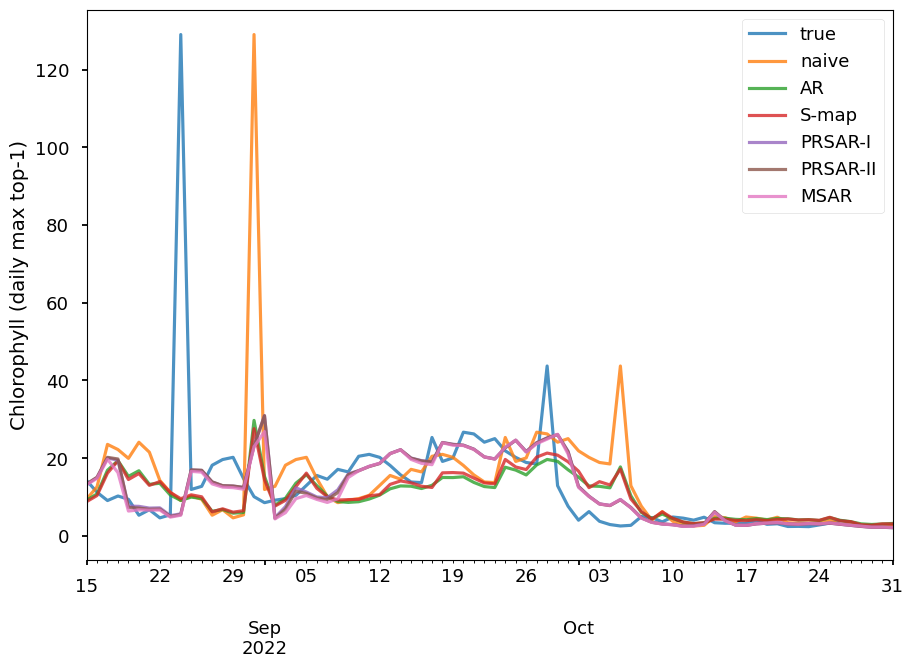

In [222]:
data_pred.resample('1D').max().plot(y = ["true", "pred_naive", "pred_ar", "pred_smap", "pred_mslrx", "pred_mslrxsolu3", "pred_mslr"], alpha = 0.8)
plt.gca().legend(["true", "naive", "AR", "S-map", "PRSAR-I", "PRSAR-II", "MSAR"])
plt.xlim(pd.Timestamp('2022-08-15'), pd.Timestamp('2022-10-31'))
plt.xlabel("")
plt.ylabel("Chlorophyll (daily max top-1)")
plt.show()

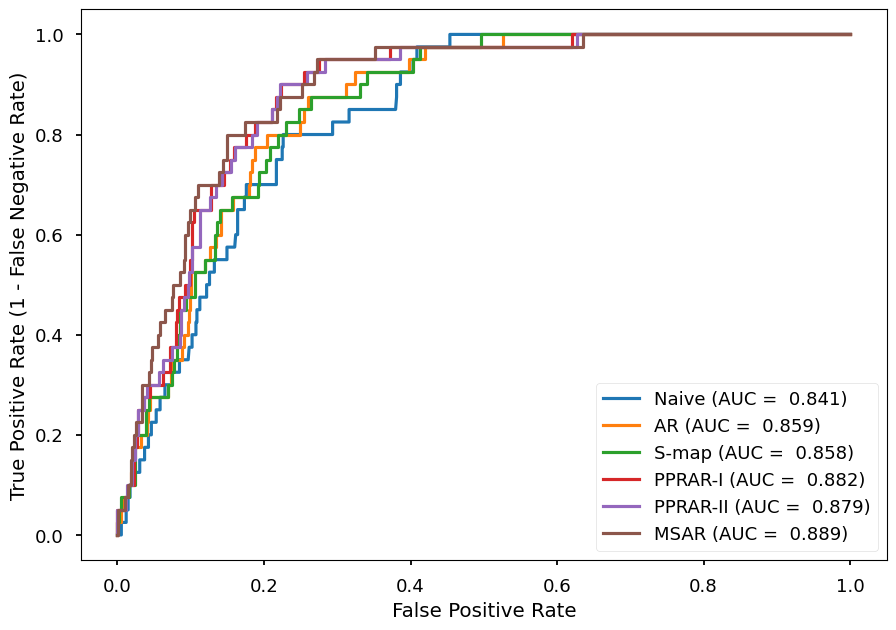

In [462]:
y_label = data_pred["true"] > data_pred["true"].quantile(0.95)

fpr, tpr, thresholds = roc_curve(y_label, data_pred["pred_naive"])
tmp_auc = roc_auc_score(y_label, data_pred["pred_naive"])
plt.plot(fpr, tpr, label = "Naive (AUC = % .3f)" % tmp_auc)

fpr, tpr, thresholds = roc_curve(y_label, data_pred["pred_ar"])
tmp_auc = roc_auc_score(y_label, data_pred["pred_ar"])
plt.plot(fpr, tpr, label = "AR (AUC = % .3f)" % tmp_auc)

fpr, tpr, thresholds = roc_curve(y_label, data_pred["pred_smap"])
tmp_auc = roc_auc_score(y_label, data_pred["pred_smap"])
plt.plot(fpr, tpr, label = "S-map (AUC = % .3f)" % tmp_auc)

fpr, tpr, thresholds = roc_curve(y_label, data_pred["pred_mslrx"])
tmp_auc = roc_auc_score(y_label, data_pred["pred_mslrx"])
plt.plot(fpr, tpr, label = "PPRAR-I (AUC = % .3f)" % tmp_auc)

fpr, tpr, thresholds = roc_curve(y_label, data_pred["pred_mslrxsolu3"])
tmp_auc = roc_auc_score(y_label, data_pred["pred_mslrxsolu3"])
plt.plot(fpr, tpr, label = "PPRAR-II (AUC = % .3f)" % tmp_auc)

fpr, tpr, thresholds = roc_curve(y_label, data_pred["pred_mslr"])
tmp_auc = roc_auc_score(y_label, data_pred["pred_mslr"])
plt.plot(fpr, tpr, label = "MSAR (AUC = % .3f)" % tmp_auc)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (1 - False Negative Rate)")
plt.legend()
plt.show()

## Analysis: by daily prediciton, by batch

In [33]:

#pred_folder = "% s_pred_truehorizon" % data_source
pred_folder = "% s_featureimportance" % data_source

dict_col_val = dict()

for tail_max in ["1stmax", "2ndmax", "90qmax"]:
    for horizon_forecast in [1, 3, 7]:
        for feature_removed in [None, "salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]:
            
            is_log = True
            is_cross = True
            tail_log = "_log" if is_log else ""
            tail_cross = "_X" if is_cross else ""
            tail_horizon = "% sD" % horizon_forecast
            tail_method = "LR"
            tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
            
            fname_read = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )

            data_pred = pd.read_csv(os.path.join("res", pred_folder, fname_read), parse_dates=["date"])
            data_pred = data_WW_byday.dropna().merge(data_pred, on = "date", how = "left").dropna().set_index("date")
            data_pred = data_pred[(data_pred["seq"] >= 3) & (data_pred["seq_index"] >= 7)]
            
            r2_naive = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_naive"])
            r2_ar = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_ar"])
            r2_smap = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_smap"])
            r2_mslrx = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_mslrx"])
            r2_mslrxsolu3 = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_mslrxsolu3"])
            r2_mslr = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_mslr"])
            
            y_label = data_pred["true"] > data_pred["true"].quantile(0.95)
            rocauc_naive = roc_auc_score(y_true = y_label, y_score = data_pred["pred_naive"])
            rocauc_ar = roc_auc_score(y_true = y_label, y_score = data_pred["pred_ar"])
            rocauc_smap = roc_auc_score(y_true = y_label, y_score = data_pred["pred_smap"])
            rocauc_mslrx = roc_auc_score(y_true = y_label, y_score = data_pred["pred_mslrx"])
            rocauc_mslrxsolu3 = roc_auc_score(y_true = y_label, y_score = data_pred["pred_mslrxsolu3"])
            rocauc_mslr = roc_auc_score(y_true = y_label, y_score = data_pred["pred_mslr"])
            
            dict_col_val[(tail_max, horizon_forecast, feature_removed)] = [r2_naive, r2_ar, r2_smap, r2_mslrx, r2_mslrxsolu3, r2_mslr, 
                                                                           rocauc_naive, rocauc_ar, rocauc_smap, rocauc_mslrx, rocauc_mslrxsolu3, rocauc_mslr]

list_metric_name = ["r2_naive", "r2_ar", "r2_smap", "r2_mslrx", "r2_mslrxsolu3", "r2_mslr",
                    "rocauc_naive", "rocauc_ar", "rocauc_smap", "rocauc_mslrx", "rocauc_mslrxsolu3", "rocauc_mslr"]
        
pd.DataFrame(dict_col_val, index = list_metric_name).to_csv(r"res/res_vimsWW_metric_pseudohorizon_0305.csv")


1stmax                                                \
                          1                                                 
                        NaN salinity_max salinity_min       ODO turbidity   
r2_naive           0.145288     0.145288     0.145288  0.145288  0.145288   
r2_ar              0.314161     0.318003     0.314795  0.314326  0.314306   
r2_smap            0.309147     0.311969     0.311264  0.310273  0.311753   
r2_mslrx           0.322196     0.333836     0.329950  0.325656  0.332187   
r2_mslrxsolu3      0.327470     0.334052     0.332518  0.325538  0.335282   
r2_mslr            0.303696     0.310480     0.311849  0.303473  0.304980   
rocauc_naive       0.926965     0.926965     0.926965  0.926965  0.926965   
rocauc_ar          0.927890     0.929898     0.927943  0.927705  0.926965   
rocauc_smap        0.927573     0.929370     0.927599  0.927652  0.926833   
rocauc_mslrx       0.923847     0.926727     0.925750  0.924640  0.925486   
rocauc_mslrxsolu3  0.925036     0.926701     0.927520  0.924508  0.926331   
rocauc_mslr        0.925591     0.927811     0.927388  0.925063  0.925036   

                                                                          \
                                                          3                
                         pH temperature      wind       NaN salinity_max   
r2_naive           0.145288    0.145288  0.145288 -0.155538    -0.155538   
r2_ar              0.314127    0.308715  0.311788  0.248918     0.241245   
r2_smap            0.310195    0.304727  0.306703  0.261497     0.254278   
r2_mslrx           0.327565    0.324785  0.322313  0.296562     0.267126   
r2_mslrxsolu3      0.329732    0.324311  0.325671  0.285466     0.262477   
r2_mslr            0.305891    0.298481  0.300743  0.297070     0.284151   
rocauc_naive       0.926965    0.926965  0.926965  0.898896     0.898896   
rocauc_ar          0.927996    0.927652  0.927520  0.896994     0.901256   
rocauc_smap        0.927758    0.927309  0.927229  0.895649     0.899454   
rocauc_mslrx       0.924561    0.925274  0.925116  0.908950     0.904059   
rocauc_mslrxsolu3  0.925406    0.924534  0.925908  0.905690     0.902457   
rocauc_mslr        0.925908    0.924799  0.924957  0.909580     0.905289   

                                                                          \
                                                                           
                  salinity_min       ODO turbidity        pH temperature   
r2_naive             -0.155538 -0.155538 -0.155538 -0.155538   -0.155538   
r2_ar                 0.243827  0.246128  0.243505  0.251144    0.241953   
r2_smap               0.258672  0.260255  0.251306  0.262975    0.254159   
r2_mslrx              0.290680  0.282976  0.264183  0.296680    0.275542   
r2_mslrxsolu3         0.279970  0.280092  0.256737  0.290421    0.270181   
r2_mslr               0.299708  0.287505  0.273198  0.295341    0.274333   
rocauc_naive          0.898896  0.898896  0.898896  0.898896    0.898896   
rocauc_ar             0.899940  0.898309  0.892646  0.899082    0.897909   
rocauc_smap           0.897880  0.896936  0.892016  0.897852    0.896793   
rocauc_mslrx          0.910180  0.911153  0.905032  0.909980    0.907892   
rocauc_mslrxsolu3     0.904831  0.910781  0.903973  0.908436    0.904717   
rocauc_mslr           0.910638  0.913785  0.907234  0.909294    0.910552   

                                                                           \
                                    7                                       
                       wind       NaN salinity_max salinity_min       ODO   
r2_naive          -0.155538 -0.514740    -0.514740    -0.514740 -0.514740   
r2_ar              0.256575  0.147454     0.151863     0.145489  0.143436   
r2_smap            0.267835  0.151927     0.153991     0.152233  0.149510   
r2_mslrx           0.299904  0.239796     0.232311     0.224091  0.244629   
r2_mslrxsolu3      0.290218  0.237701     0.

In [41]:

#pred_folder = "% s_pred_truehorizon" % data_source
#pred_folder = "% s_featureimportance" % data_source
#pred_folder = "% s_pred_truehorizon" % data_source
pred_folder = "% s_nocross" % data_source

fname_write = r"res/res_vimsWW_metric_noX_pseudohorizon_0305.csv"
#fname_write = r"res/res_vimsWW_metric_noX_truehorizon_0305.csv"

dict_col_val = dict()

for tail_max in ["1stmax", "2ndmax", "90qmax"]:
    for horizon_forecast in [1, 3, 7]:
    #for horizon_forecast in [3, 7]:
        for feature_removed in [None, ]:
            
            is_log = True
            is_cross = False
            tail_log = "_log" if is_log else ""
            tail_cross = "_X" if is_cross else ""
            tail_horizon = "% sD" % horizon_forecast
            tail_method = "LR"
            if is_cross:
                tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
            else:
                tail_removed_features = "noX" 
            
            fname_read = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )

            data_pred = pd.read_csv(os.path.join("res", pred_folder, fname_read), parse_dates=["date"])
            data_pred = data_WW_byday.dropna().merge(data_pred, on = "date", how = "left").dropna().set_index("date")
            data_pred = data_pred[(data_pred["seq"] >= 3) & (data_pred["seq_index"] >= 7)]
            
            r2_naive = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_naive"])
            r2_ar = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_ar"])
            r2_smap = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_smap"])
            r2_mslrx = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_mslrx"])
            r2_mslrxsolu3 = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_mslrxsolu3"])
            r2_mslr = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_mslr"])
            
            y_label = data_pred["true"] > data_pred["true"].quantile(0.95)
            rocauc_naive = roc_auc_score(y_true = y_label, y_score = data_pred["pred_naive"])
            rocauc_ar = roc_auc_score(y_true = y_label, y_score = data_pred["pred_ar"])
            rocauc_smap = roc_auc_score(y_true = y_label, y_score = data_pred["pred_smap"])
            rocauc_mslrx = roc_auc_score(y_true = y_label, y_score = data_pred["pred_mslrx"])
            rocauc_mslrxsolu3 = roc_auc_score(y_true = y_label, y_score = data_pred["pred_mslrxsolu3"])
            rocauc_mslr = roc_auc_score(y_true = y_label, y_score = data_pred["pred_mslr"])
            
            dict_col_val[(tail_max, horizon_forecast, feature_removed)] = [r2_naive, r2_ar, r2_smap, r2_mslrx, r2_mslrxsolu3, r2_mslr, 
                                                                           rocauc_naive, rocauc_ar, rocauc_smap, rocauc_mslrx, rocauc_mslrxsolu3, rocauc_mslr]

list_metric_name = ["r2_naive", "r2_ar", "r2_smap", "r2_mslrx", "r2_mslrxsolu3", "r2_mslr",
                    "rocauc_naive", "rocauc_ar", "rocauc_smap", "rocauc_mslrx", "rocauc_mslrxsolu3", "rocauc_mslr"]
        
pd.DataFrame(dict_col_val, index = list_metric_name).to_csv(fname_write)


In [69]:

#pred_folder = "% s_pred_truehorizon" % data_source
#pred_folder = "% s_featureimportance" % data_source
pred_folder = "% s_pred_truehorizon" % data_source
#pred_folder = "% s_nocross" % data_source

#fname_write = r"res/res_vimsWW_metric_noX_pseudohorizon_0305.csv"
#fname_write = r"res/res_vimsWW_metric_noX_truehorizon_0305.csv"
fname_write = r"res/res_vimsWW_metric_allX_truehorizon_0305.csv"

dict_col_val = dict()

for tail_max in ["1stmax", "2ndmax", "90qmax"]:
    #for horizon_forecast in [1, 3, 7]:
    for horizon_forecast in [3, 7]:
        for feature_removed in [None, ]:
            
            is_log = True
            is_cross = True
            tail_log = "_log" if is_log else ""
            tail_cross = "_X" if is_cross else ""
            tail_horizon = "% sD" % horizon_forecast
            tail_method = "LR"
            if is_cross:
                tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
            else:
                tail_removed_features = "noX" 
            
            fname_read = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )

            data_pred = pd.read_csv(os.path.join("res", pred_folder, fname_read), parse_dates=["date"])
            data_pred = data_WW_byday.dropna().merge(data_pred, on = "date", how = "left").dropna().set_index("date")
            data_pred = data_pred[(data_pred["seq"] >= 3) & (data_pred["seq_index"] >= 7)]
            
            r2_naive = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_naive"])
            r2_ar = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_ar"])
            r2_smap = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_smap"])
            r2_mslrx = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_mslrx"])
            r2_mslrxsolu3 = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_mslrxsolu3"])
            r2_mslr = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_mslr"])
            
            y_label = data_pred["true"] > data_pred["true"].quantile(0.95)
            rocauc_naive = roc_auc_score(y_true = y_label, y_score = data_pred["pred_naive"])
            rocauc_ar = roc_auc_score(y_true = y_label, y_score = data_pred["pred_ar"])
            rocauc_smap = roc_auc_score(y_true = y_label, y_score = data_pred["pred_smap"])
            rocauc_mslrx = roc_auc_score(y_true = y_label, y_score = data_pred["pred_mslrx"])
            rocauc_mslrxsolu3 = roc_auc_score(y_true = y_label, y_score = data_pred["pred_mslrxsolu3"])
            rocauc_mslr = roc_auc_score(y_true = y_label, y_score = data_pred["pred_mslr"])
            
            dict_col_val[(tail_max, horizon_forecast, feature_removed)] = [r2_naive, r2_ar, r2_smap, r2_mslrx, r2_mslrxsolu3, r2_mslr, 
                                                                           rocauc_naive, rocauc_ar, rocauc_smap, rocauc_mslrx, rocauc_mslrxsolu3, rocauc_mslr]

list_metric_name = ["r2_naive", "r2_ar", "r2_smap", "r2_mslrx", "r2_mslrxsolu3", "r2_mslr",
                    "rocauc_naive", "rocauc_ar", "rocauc_smap", "rocauc_mslrx", "rocauc_mslrxsolu3", "rocauc_mslr"]
        
pd.DataFrame(dict_col_val, index = list_metric_name).to_csv(fname_write)
pd.DataFrame(dict_col_val, index = list_metric_name)


1stmax              2ndmax              90qmax          
                          3         7         3         7         3         7
                        NaN       NaN       NaN       NaN       NaN       NaN
r2_naive          -0.187811 -0.479395  0.353593 -0.049726  0.606076  0.208249
r2_ar              0.231806  0.134243  0.459024  0.275307  0.651821  0.194903
r2_smap            0.243499  0.138657  0.464009  0.278258  0.643945  0.199757
r2_mslrx           0.249096  0.141237  0.458421  0.289843  0.595541  0.098479
r2_mslrxsolu3      0.248855  0.146696  0.454373  0.293446  0.597356  0.128825
r2_mslr            0.244985  0.121115  0.464865  0.242790  0.607274  0.188227
rocauc_naive       0.892447  0.846621  0.927509  0.891211  0.883383  0.731484
rocauc_ar          0.892007  0.847886  0.926354  0.895481  0.881860  0.736230
rocauc_smap        0.890276  0.847554  0.925869  0.892620  0.879493  0.737567
rocauc_mslrx       0.887694  0.844279  0.919916  0.874959  0.887104  0.719920
rocauc_mslrxsolu3  0.890124  0.844900  0.920797  0.890050  0.881522  0.697861
rocauc_mslr        0.886085  0.841501  0.922741  0.871891  0.878140  0.671390

In [57]:

#pred_folder = "% s_pred_truehorizon" % data_source
#pred_folder = "% s_featureimportance" % data_source
# pred_folder = "% s_pred_truehorizon" % data_source
#pred_folder = "% s_nocross" % data_source
pred_folder = "% s_pred_truehorizon_smooth" % data_source

#fname_write = r"res/res_vimsWW_metric_noX_pseudohorizon_0305.csv"
#fname_write = r"res/res_vimsWW_metric_noX_truehorizon_0305.csv"
fname_write = r"res/res_vimsWW_metric_allX_smooth_truehorizon_0420.csv"

dict_col_val = dict()

# for tail_max in ["smoothmeanstd5", "smoothmeanstd7", "smoothmeanstd8", "smoothmeanstd9", "smoothmeanstd10", "smoothmeanstd12", "smoothmeanstd13", "smoothmeanstd14", ]:
for tail_max in ["smoothmeanstd12", "smoothmeanstd14", ]:
    for horizon_forecast in [1, 3, 7]:
    #for horizon_forecast in [3, 7]:
        for feature_removed in [None, ]:
            
            is_log = True
            is_cross = True
            tail_log = "_log" if is_log else ""
            tail_cross = "_X" if is_cross else ""
            tail_horizon = "% sD" % horizon_forecast
            tail_method = "LR"
            if is_cross:
                tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
            else:
                tail_removed_features = "noX" 
            
            fname_read = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )

            data_pred = pd.read_csv(os.path.join("res", pred_folder, fname_read), parse_dates=["date"])
            data_pred = data_WW_byday.dropna().merge(data_pred, on = "date", how = "left").dropna().set_index("date")
            # data_pred = data_pred[(data_pred["seq"] >= 3) & (data_pred["seq_index"] >= 7)]
            data_pred = data_pred[(data_pred["seq"] >= 9) & (data_pred["seq_index"] >= 5) & (data_pred.index >= pd.Timestamp("2022-01-01"))]
            
            r2_naive = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_naive"])
            r2_ar = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_ar"])
            r2_smap = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_smap"])
            r2_mslrx = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_mslrx"])
            r2_mslrxsolu3 = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_mslrxsolu3"])
            r2_mslr = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_mslr"])
            
            y_label = data_pred["true"] > data_pred["true"].quantile(0.95)
            rocauc_naive = roc_auc_score(y_true = y_label, y_score = data_pred["pred_naive"])
            rocauc_ar = roc_auc_score(y_true = y_label, y_score = data_pred["pred_ar"])
            rocauc_smap = roc_auc_score(y_true = y_label, y_score = data_pred["pred_smap"])
            rocauc_mslrx = roc_auc_score(y_true = y_label, y_score = data_pred["pred_mslrx"])
            rocauc_mslrxsolu3 = roc_auc_score(y_true = y_label, y_score = data_pred["pred_mslrxsolu3"])
            rocauc_mslr = roc_auc_score(y_true = y_label, y_score = data_pred["pred_mslr"])
            
            dict_col_val[(tail_max, horizon_forecast, feature_removed)] = [r2_naive, r2_ar, r2_smap, r2_mslrx, r2_mslrxsolu3, r2_mslr, 
                                                                           rocauc_naive, rocauc_ar, rocauc_smap, rocauc_mslrx, rocauc_mslrxsolu3, rocauc_mslr]

list_metric_name = ["r2_persistent", "r2_ar", "r2_smap", "r2_mslrx", "r2_mslrxsolu3", "r2_mslr",
                    "rocauc_persistent", "rocauc_ar", "rocauc_smap", "rocauc_mslrx", "rocauc_mslrxsolu3", "rocauc_mslr"]
        
# pd.DataFrame(dict_col_val, index = list_metric_name).to_csv(fname_write)
pd.DataFrame(dict_col_val, index = list_metric_name)


smoothmeanstd12                     smoothmeanstd14  \
                                1         3         7               1   
                              NaN       NaN       NaN             NaN   
r2_persistent            0.586701  0.295951 -0.033551        0.586626   
r2_ar                    0.620268  0.383720  0.169456        0.627670   
r2_smap                  0.624369  0.378952  0.179397        0.632750   
r2_mslrx                 0.623936  0.433518  0.126511        0.638343   
r2_mslrxsolu3            0.620027  0.429215  0.142660        0.633964   
r2_mslr                  0.632529  0.419269  0.134997        0.638584   
rocauc_persistent        0.911348  0.840754  0.715637        0.911348   
rocauc_ar                0.918676  0.860827  0.768285        0.918440   
rocauc_smap              0.920804  0.858394  0.788777        0.920804   
rocauc_mslrx             0.912293  0.853771  0.806747        0.914421   
rocauc_mslrxsolu3        0.912530  0.848418  0.793821        0.914421   
rocauc_mslr              0.913948  0.849148  0.805801        0.915366   

                                       
                          3         7  
                        NaN       NaN  
r2_persistent      0.295810 -0.033582  
r2_ar              0.388718  0.175149  
r2_smap            0.385829  0.186202  
r2_mslrx           0.438303  0.133811  
r2_mslrxsolu3      0.437375  0.145798  
r2_mslr            0.422599  0.138959  
rocauc_persistent  0.840754  0.715637  
rocauc_ar          0.861800  0.768916  
rocauc_smap        0.859854  0.790353  
rocauc_mslrx       0.855474  0.808323  
rocauc_mslrxsolu3  0.848175  0.789407  
rocauc_mslr        0.850122  0.806116

In [15]:

#pred_folder = "% s_pred_truehorizon" % data_source
#pred_folder = "% s_featureimportance" % data_source
# pred_folder = "% s_pred_truehorizon" % data_source
#pred_folder = "% s_nocross" % data_source
pred_folder = "% s_pred_truehorizon_smooth" % data_source

#fname_write = r"res/res_vimsWW_metric_noX_pseudohorizon_0305.csv"
#fname_write = r"res/res_vimsWW_metric_noX_truehorizon_0305.csv"
# fname_write = r"res/res_vimsWW_metric_allX_smooth_truehorizon_0420.csv"
fname_write = r"res/res_vimsWW_metric_allX_smooth_truehorizon_0613.csv"

dict_col_val = dict()

# for tail_max in ["smoothmeanstd5", "smoothmeanstd7", "smoothmeanstd8", "smoothmeanstd9", "smoothmeanstd10", "smoothmeanstd12", "smoothmeanstd13", "smoothmeanstd14", ]:
for tail_max in ["smoothmeanstd14", ]:
    # for horizon_forecast in [1, 3, 7]:
    for horizon_forecast in [1, 2, 3, 4, 5, 6, 7]:
        for feature_removed in [None, ]:
            
            is_log = True
            is_cross = False
            tail_log = "_log" if is_log else ""
            tail_cross = "_X" if is_cross else ""
            tail_horizon = "% sD" % horizon_forecast
            tail_method = "LR"
            if is_cross:
                tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
            else:
                tail_removed_features = "noX" 
            
            fname_read = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )

            data_pred = pd.read_csv(os.path.join("res", pred_folder, fname_read), parse_dates=["date"])
            data_pred = data_WW_byday.dropna().merge(data_pred, on = "date", how = "left").dropna().set_index("date")
            # data_pred = data_pred[(data_pred["seq"] >= 3) & (data_pred["seq_index"] >= 7)]
            data_pred = data_pred[(data_pred["seq"] >= 9) & (data_pred["seq_index"] >= 5) & (data_pred.index >= pd.Timestamp("2022-01-01"))]
            
            r2_naive = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_naive"])
            r2_ar = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_ar"])
            r2_smap = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_smap"])
            r2_mslrx = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_mslrx"])
            r2_mslrxsolu3 = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_mslrxsolu3"])
            r2_mslr = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_mslr"])
            
            y_label = data_pred["true"] > data_pred["true"].quantile(0.95)
            rocauc_naive = roc_auc_score(y_true = y_label, y_score = data_pred["pred_naive"])
            rocauc_ar = roc_auc_score(y_true = y_label, y_score = data_pred["pred_ar"])
            rocauc_smap = roc_auc_score(y_true = y_label, y_score = data_pred["pred_smap"])
            rocauc_mslrx = roc_auc_score(y_true = y_label, y_score = data_pred["pred_mslrx"])
            rocauc_mslrxsolu3 = roc_auc_score(y_true = y_label, y_score = data_pred["pred_mslrxsolu3"])
            rocauc_mslr = roc_auc_score(y_true = y_label, y_score = data_pred["pred_mslr"])
            
            dict_col_val[(tail_max, horizon_forecast, feature_removed)] = [r2_naive, r2_ar, r2_smap, r2_mslrx, r2_mslrxsolu3, r2_mslr, 
                                                                           rocauc_naive, rocauc_ar, rocauc_smap, rocauc_mslrx, rocauc_mslrxsolu3, rocauc_mslr]

list_metric_name = ["r2_persistent", "r2_ar", "r2_smap", "r2_mslrx", "r2_mslrxsolu3", "r2_mslr",
                    "rocauc_persistent", "rocauc_ar", "rocauc_smap", "rocauc_mslrx", "rocauc_mslrxsolu3", "rocauc_mslr"]
        
# pd.DataFrame(dict_col_val, index = list_metric_name).to_csv(fname_write)
pd.DataFrame(dict_col_val, index = list_metric_name)


smoothmeanstd14                                          \
                                1         2         3         4         5   
                              NaN       NaN       NaN       NaN       NaN   
r2_persistent            0.589249  0.441997  0.299185  0.199054  0.126822   
r2_ar                    0.628495  0.501143  0.394306  0.337442  0.292830   
r2_smap                  0.625557  0.510097  0.403180  0.349168  0.310692   
r2_mslrx                 0.640204  0.509215  0.391941  0.304434  0.253097   
r2_mslrxsolu3            0.641234  0.515199  0.395443  0.280709  0.284321   
r2_mslr                  0.626688  0.516178  0.405004  0.340247  0.283161   
rocauc_persistent        0.927423  0.906115  0.848297  0.778090  0.734418   
rocauc_ar                0.926950  0.905995  0.843796  0.776083  0.737452   
rocauc_smap              0.927423  0.905036  0.842822  0.772873  0.737176   
rocauc_mslrx             0.928132  0.899041  0.829440  0.752006  0.704357   
rocauc_mslrxsolu3        0.928369  0.902638  0.827251  0.736490  0.727248   
rocauc_mslr              0.927423  0.902158  0.836983  0.754414  0.706839   

                                       
                          6         7  
                        NaN       NaN  
r2_persistent      0.034257 -0.029785  
r2_ar              0.248847  0.216445  
r2_smap            0.269166  0.239191  
r2_mslrx           0.168810  0.124661  
r2_mslrxsolu3      0.221913  0.173756  
r2_mslr            0.247694  0.231444  
rocauc_persistent  0.724957  0.696721  
rocauc_ar          0.725669  0.708386  
rocauc_smap        0.724246  0.704918  
rocauc_mslrx       0.704895  0.702081  
rocauc_mslrxsolu3  0.707740  0.731400  
rocauc_mslr        0.704610  0.697982

In [66]:

#pred_folder = "% s_pred_truehorizon" % data_source
#pred_folder = "% s_featureimportance" % data_source
# pred_folder = "% s_pred_truehorizon" % data_source
#pred_folder = "% s_nocross" % data_source
pred_folder = "% s_pred_truehorizon_smooth" % data_source

#fname_write = r"res/res_vimsWW_metric_noX_pseudohorizon_0305.csv"
#fname_write = r"res/res_vimsWW_metric_noX_truehorizon_0305.csv"
fname_write = r"res/res_vimsWW_metric_allX_smooth_truehorizon_0420.csv"
# fname_write = r"res/res_vimsWW_metric_noX_smooth_truehorizon_0420.csv"

dict_col_val = dict()

# for tail_max in ["smoothmeanstd5", "smoothmeanstd7", "smoothmeanstd8", "smoothmeanstd9", "smoothmeanstd10", "smoothmeanstd12", "smoothmeanstd13", "smoothmeanstd14", ]:
for tail_max in ["smoothmeanstd14", ]:
    # for horizon_forecast in [1, 3, 7]:
    for horizon_forecast in [1, 2, 3, 4, 5, 6, 7]:
        for feature_removed in [None, ]:
            
            is_log = True
            is_cross = True
            # is_cross = False
            tail_log = "_log" if is_log else ""
            tail_cross = "_X" if is_cross else ""
            tail_horizon = "% sD" % horizon_forecast
            tail_method = "LR"
            if is_cross:
                tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
            else:
                tail_removed_features = "noX" 
            
            fname_read = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )

            data_pred = pd.read_csv(os.path.join("res", pred_folder, fname_read), parse_dates=["date"])
            data_pred = data_WW_byday.dropna().merge(data_pred, on = "date", how = "left").dropna().set_index("date")
            # data_pred = data_pred[(data_pred["seq"] >= 3) & (data_pred["seq_index"] >= 7)]
            data_pred = data_pred[(data_pred["seq"] >= 9) & (data_pred["seq_index"] >= 5) & (data_pred.index >= pd.Timestamp("2022-01-01"))]
            
            r2_naive = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_naive"])
            r2_ar = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_ar"])
            r2_smap = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_smap"])
            r2_mslrx = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_mslrx"])
            r2_mslrxsolu3 = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_mslrxsolu3"])
            r2_mslr = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_mslr"])
            
            y_label = data_pred["true"] > data_pred["true"].quantile(0.95)
            rocauc_naive = roc_auc_score(y_true = y_label, y_score = data_pred["pred_naive"])
            rocauc_ar = roc_auc_score(y_true = y_label, y_score = data_pred["pred_ar"])
            rocauc_smap = roc_auc_score(y_true = y_label, y_score = data_pred["pred_smap"])
            rocauc_mslrx = roc_auc_score(y_true = y_label, y_score = data_pred["pred_mslrx"])
            rocauc_mslrxsolu3 = roc_auc_score(y_true = y_label, y_score = data_pred["pred_mslrxsolu3"])
            rocauc_mslr = roc_auc_score(y_true = y_label, y_score = data_pred["pred_mslr"])
            
            dict_col_val[(tail_max, horizon_forecast, feature_removed)] = [r2_naive, r2_ar, r2_smap, r2_mslrx, r2_mslrxsolu3, r2_mslr, 
                                                                           rocauc_naive, rocauc_ar, rocauc_smap, rocauc_mslrx, rocauc_mslrxsolu3, rocauc_mslr]

list_metric_name = ["r2_persistent", "r2_ar", "r2_smap", "r2_mslrx", "r2_mslrxsolu3", "r2_mslr",
                    "rocauc_persistent", "rocauc_ar", "rocauc_smap", "rocauc_mslrx", "rocauc_mslrxsolu3", "rocauc_mslr"]
        
pd.DataFrame(dict_col_val, index = list_metric_name).to_csv(fname_write)
pd.DataFrame(dict_col_val, index = list_metric_name)


smoothmeanstd14                                          \
                                1         2         3         4         5   
                              NaN       NaN       NaN       NaN       NaN   
r2_persistent            0.586626  0.439128  0.295810  0.195052  0.121811   
r2_ar                    0.627670  0.475854  0.388718  0.240959  0.274188   
r2_smap                  0.632750  0.478812  0.385829  0.240127  0.281758   
r2_mslrx                 0.638343  0.530723  0.438303  0.346180  0.208592   
r2_mslrxsolu3            0.633964  0.536307  0.437375  0.279686  0.208221   
r2_mslr                  0.638584  0.543615  0.422599  0.325646  0.239925   
rocauc_persistent        0.911348  0.906595  0.840754  0.761771  0.709597   
rocauc_ar                0.918440  0.898082  0.861800  0.785982  0.763376   
rocauc_smap              0.920804  0.899520  0.859854  0.787319  0.767512   
rocauc_mslrx             0.914421  0.907434  0.855474  0.748261  0.717319   
rocauc_mslrxsolu3        0.914421  0.905995  0.848175  0.755217  0.688638   
rocauc_mslr              0.915366  0.901199  0.850122  0.748796  0.732212   

                                       
                          6         7  
                        NaN       NaN  
r2_persistent      0.029789 -0.033582  
r2_ar              0.229458  0.175149  
r2_smap            0.238234  0.186202  
r2_mslrx           0.149002  0.133811  
r2_mslrxsolu3      0.140661  0.145798  
r2_mslr            0.192254  0.138959  
rocauc_persistent  0.699630  0.715637  
rocauc_ar          0.757826  0.768916  
rocauc_smap        0.769493  0.790353  
rocauc_mslrx       0.736198  0.808323  
rocauc_mslrxsolu3  0.710017  0.789407  
rocauc_mslr        0.754126  0.806116

In [51]:
data_pred

,conductivity,turbidity,temperature,pH,ODO,salinity_max,salinity_min,log10_chlorophyll,chlorophyll,wind,true,pred_naive,pred_mslrx,pred_mslr,pred_mslrxsolu3,pred_ar,pred_smap,seq,seq_index
date,,,,,,,,,,,,,,,,,,,
2022-01-31,49.264,216.67,1.399104,8.006667,11.28,30.88,27.29,1.120903,13.21,4.164167,13.21,8.27,4.164445,5.200204,4.176970,3.592868,4.046434,12.0,9.0
2022-02-01,49.261,111.49,2.127885,8.001250,10.85,31.08,27.36,1.116276,13.07,3.457407,13.07,9.02,4.510293,5.432774,4.525798,4.240955,4.795268,12.0,10.0
2022-02-02,49.299,51.59,3.102094,8.001042,11.10,31.25,27.72,1.172895,14.89,2.244005,14.89,10.81,4.742018,5.595589,4.739698,4.590786,4.292171,12.0,11.0
2022-02-03,48.649,30.48,4.403104,8.007187,11.05,30.98,27.72,1.168792,14.75,1.940787,14.75,10.60,4.711154,5.512385,4.832874,4.418791,4.996773,12.0,12.0
2022-02-04,47.793,994.41,6.033635,7.997500,10.63,30.48,27.28,1.687529,48.70,4.259120,48.70,10.57,4.787492,5.450164,4.943315,4.489522,5.289921,12.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-05,49.389,55.59,8.995865,7.920104,8.75,32.04,30.61,0.296665,1.98,1.973750,1.98,2.10,4.393424,4.056539,4.220017,3.225728,3.138204,15.0,33.0
2022-12-06,49.362,12.87,9.378375,7.921146,8.74,32.05,30.74,0.305351,2.02,2.282292,2.02,1.88,3.410718,3.102748,3.287173,2.689269,2.667619,15.0,34.0
2022-12-07,49.214,6.61,10.651365,7.896146,8.60,31.99,30.68,0.363612,2.31,2.356296,2.31,2.35,3.199668,2.927853,3.080350,2.739432,2.781127,15.0,35.0


In [13]:

#pred_folder = "% s_pred_truehorizon" % data_source
#pred_folder = "% s_featureimportance" % data_source
# pred_folder = "% s_pred_truehorizon" % data_source
#pred_folder = "% s_nocross" % data_source
pred_folder = "vimsWW_pred_truehorizon_smooth"

#fname_write = r"res/res_vimsWW_metric_noX_pseudohorizon_0305.csv"
#fname_write = r"res/res_vimsWW_metric_noX_truehorizon_0305.csv"
# fname_write = r"res/res_vimsWW_metric_allX_smooth_truehorizon_0411.csv"
fname_write = r"res/res_vimsWW_metric_noX_smooth_truehorizon_0613.csv"

dict_col_val = dict()

for tail_max in ["smooth"]:
    for horizon_forecast in [1, 3, 7]:
    #for horizon_forecast in [3, 7]:
        for feature_removed in [None, ]:
            
            is_log = True
            is_cross = False
            tail_log = "_log" if is_log else ""
            tail_cross = "_X" if is_cross else ""
            tail_horizon = "% sD" % horizon_forecast
            tail_method = "LR"
            if is_cross:
                tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
            else:
                tail_removed_features = "noX" 
            
            fname_read = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )

            data_pred = pd.read_csv(os.path.join("res", pred_folder, fname_read), parse_dates=["date"])
            data_pred = data_WW_byday.dropna().merge(data_pred, on = "date", how = "left").dropna().set_index("date")
            data_pred = data_pred[(data_pred["seq"] >= 3) & (data_pred["seq_index"] >= 7)]
            
            r2_naive = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_naive"])
            r2_ar = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_ar"])
            r2_smap = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_smap"])
            r2_mslrx = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_mslrx"])
            r2_mslrxsolu3 = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_mslrxsolu3"])
            r2_mslr = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_mslr"])
            
            y_label = data_pred["true"] > data_pred["true"].quantile(0.95)
            rocauc_naive = roc_auc_score(y_true = y_label, y_score = data_pred["pred_naive"])
            rocauc_ar = roc_auc_score(y_true = y_label, y_score = data_pred["pred_ar"])
            rocauc_smap = roc_auc_score(y_true = y_label, y_score = data_pred["pred_smap"])
            rocauc_mslrx = roc_auc_score(y_true = y_label, y_score = data_pred["pred_mslrx"])
            rocauc_mslrxsolu3 = roc_auc_score(y_true = y_label, y_score = data_pred["pred_mslrxsolu3"])
            rocauc_mslr = roc_auc_score(y_true = y_label, y_score = data_pred["pred_mslr"])
            
            dict_col_val[(tail_max, horizon_forecast, feature_removed)] = [r2_naive, r2_ar, r2_smap, r2_mslrx, r2_mslrxsolu3, r2_mslr, 
                                                                           rocauc_naive, rocauc_ar, rocauc_smap, rocauc_mslrx, rocauc_mslrxsolu3, rocauc_mslr]

list_metric_name = ["r2_naive", "r2_ar", "r2_smap", "r2_mslrx", "r2_mslrxsolu3", "r2_mslr",
                    "rocauc_naive", "rocauc_ar", "rocauc_smap", "rocauc_mslrx", "rocauc_mslrxsolu3", "rocauc_mslr"]
        
pd.DataFrame(dict_col_val, index = list_metric_name).to_csv(fname_write)
pd.DataFrame(dict_col_val, index = list_metric_name)


smooth                    
                          1         3         7
                        NaN       NaN       NaN
r2_naive           0.725666  0.404686 -0.048826
r2_ar              0.750475  0.498592  0.210411
r2_smap            0.751963  0.504536  0.216454
r2_mslrx           0.750960  0.512578  0.135957
r2_mslrxsolu3      0.746480  0.507422  0.198694
r2_mslr            0.747493  0.494796  0.238237
rocauc_naive       0.949371  0.924567  0.698997
rocauc_ar          0.949576  0.928710  0.704679
rocauc_smap        0.949781  0.930148  0.701337
rocauc_mslrx       0.948002  0.938858  0.760829
rocauc_mslrxsolu3  0.948071  0.936152  0.709225
rocauc_mslr        0.949644  0.937336  0.712701

In [11]:

#pred_folder = "% s_pred_truehorizon" % data_source
#pred_folder = "% s_featureimportance" % data_source
# pred_folder = "% s_pred_truehorizon" % data_source
#pred_folder = "% s_nocross" % data_source
pred_folder = "% s_pred_truehorizon1step" % data_source

#fname_write = r"res/res_vimsWW_metric_noX_pseudohorizon_0305.csv"
#fname_write = r"res/res_vimsWW_metric_noX_truehorizon_0305.csv"
fname_write = r"res/res_vimsWW_metric_allX_smooth_truehorizon1step_0411.csv"

dict_col_val = dict()

for tail_max in ["smooth"]:
    for horizon_forecast in [1, 3, 7]:
    #for horizon_forecast in [3, 7]:
        for feature_removed in [None, ]:
            
            is_log = True
            is_cross = True
            tail_log = "_log" if is_log else ""
            tail_cross = "_X" if is_cross else ""
            tail_horizon = "% sD" % horizon_forecast
            tail_method = "LR"
            if is_cross:
                tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
            else:
                tail_removed_features = "noX" 
            
            fname_read = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )

            data_pred = pd.read_csv(os.path.join("res", pred_folder, fname_read), parse_dates=["date"])
            data_pred = data_WW_byday.dropna().merge(data_pred, on = "date", how = "left").dropna().set_index("date")
            data_pred = data_pred[(data_pred["seq"] >= 3) & (data_pred["seq_index"] >= 7)]
            
            r2_naive = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_naive"])
            r2_ar = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_ar"])
            r2_smap = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_smap"])
            r2_mslrx = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_mslrx"])
            r2_mslrxsolu3 = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_mslrxsolu3"])
            r2_mslr = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_mslr"])
            
            y_label = data_pred["true"] > data_pred["true"].quantile(0.95)
            rocauc_naive = roc_auc_score(y_true = y_label, y_score = data_pred["pred_naive"])
            rocauc_ar = roc_auc_score(y_true = y_label, y_score = data_pred["pred_ar"])
            rocauc_smap = roc_auc_score(y_true = y_label, y_score = data_pred["pred_smap"])
            rocauc_mslrx = roc_auc_score(y_true = y_label, y_score = data_pred["pred_mslrx"])
            rocauc_mslrxsolu3 = roc_auc_score(y_true = y_label, y_score = data_pred["pred_mslrxsolu3"])
            rocauc_mslr = roc_auc_score(y_true = y_label, y_score = data_pred["pred_mslr"])
            
            dict_col_val[(tail_max, horizon_forecast, feature_removed)] = [r2_naive, r2_ar, r2_smap, r2_mslrx, r2_mslrxsolu3, r2_mslr, 
                                                                           rocauc_naive, rocauc_ar, rocauc_smap, rocauc_mslrx, rocauc_mslrxsolu3, rocauc_mslr]

list_metric_name = ["r2_naive", "r2_ar", "r2_smap", "r2_mslrx", "r2_mslrxsolu3", "r2_mslr",
                    "rocauc_naive", "rocauc_ar", "rocauc_smap", "rocauc_mslrx", "rocauc_mslrxsolu3", "rocauc_mslr"]
        
#pd.DataFrame(dict_col_val, index = list_metric_name).to_csv(fname_write)
pd.DataFrame(dict_col_val, index = list_metric_name)


smooth                    
                          1         3         7
                        NaN       NaN       NaN
r2_naive           0.725666  0.440737  0.039192
r2_ar              0.744096  0.483002  0.249734
r2_smap            0.747087  0.479384  0.255747
r2_mslrx           0.749686  0.438501  0.215159
r2_mslrxsolu3      0.748894  0.420065 -1.534691
r2_mslr            0.747567  0.483425  0.161469
rocauc_naive       0.949371  0.924175  0.758454
rocauc_ar          0.943487  0.896490  0.789598
rocauc_smap        0.943897  0.891199  0.791448
rocauc_mslrx       0.942323  0.909457  0.772433
rocauc_mslrxsolu3  0.942323  0.912736  0.768835
rocauc_mslr        0.944650  0.905284  0.757632

In [13]:

#pred_folder = "% s_pred_truehorizon" % data_source
#pred_folder = "% s_featureimportance" % data_source
# pred_folder = "% s_pred_truehorizon" % data_source
#pred_folder = "% s_nocross" % data_source
pred_folder = "% s_pred_truehorizon1step" % data_source

#fname_write = r"res/res_vimsWW_metric_noX_pseudohorizon_0305.csv"
#fname_write = r"res/res_vimsWW_metric_noX_truehorizon_0305.csv"
fname_write = r"res/res_vimsWW_metric_allX_smooth_truehorizon1step_0411.csv"

dict_col_val = dict()

for tail_max in ["smooth"]:
    for horizon_forecast in [1, 3, 7]:
    #for horizon_forecast in [3, 7]:
        for feature_removed in [None, ]:
            
            is_log = True
            is_cross = False
            tail_log = "_log" if is_log else ""
            tail_cross = "_X" if is_cross else ""
            tail_horizon = "% sD" % horizon_forecast
            tail_method = "LR"
            if is_cross:
                tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
            else:
                tail_removed_features = "noX" 
            
            fname_read = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )

            data_pred = pd.read_csv(os.path.join("res", pred_folder, fname_read), parse_dates=["date"])
            data_pred = data_WW_byday.dropna().merge(data_pred, on = "date", how = "left").dropna().set_index("date")
            data_pred = data_pred[(data_pred["seq"] >= 3) & (data_pred["seq_index"] >= 7)]
            
            r2_naive = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_naive"])
            r2_ar = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_ar"])
            r2_smap = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_smap"])
            r2_mslrx = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_mslrx"])
            r2_mslrxsolu3 = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_mslrxsolu3"])
            r2_mslr = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_mslr"])
            
            y_label = data_pred["true"] > data_pred["true"].quantile(0.95)
            rocauc_naive = roc_auc_score(y_true = y_label, y_score = data_pred["pred_naive"])
            rocauc_ar = roc_auc_score(y_true = y_label, y_score = data_pred["pred_ar"])
            rocauc_smap = roc_auc_score(y_true = y_label, y_score = data_pred["pred_smap"])
            rocauc_mslrx = roc_auc_score(y_true = y_label, y_score = data_pred["pred_mslrx"])
            rocauc_mslrxsolu3 = roc_auc_score(y_true = y_label, y_score = data_pred["pred_mslrxsolu3"])
            rocauc_mslr = roc_auc_score(y_true = y_label, y_score = data_pred["pred_mslr"])
            
            dict_col_val[(tail_max, horizon_forecast, feature_removed)] = [r2_naive, r2_ar, r2_smap, r2_mslrx, r2_mslrxsolu3, r2_mslr, 
                                                                           rocauc_naive, rocauc_ar, rocauc_smap, rocauc_mslrx, rocauc_mslrxsolu3, rocauc_mslr]

list_metric_name = ["r2_naive", "r2_ar", "r2_smap", "r2_mslrx", "r2_mslrxsolu3", "r2_mslr",
                    "rocauc_naive", "rocauc_ar", "rocauc_smap", "rocauc_mslrx", "rocauc_mslrxsolu3", "rocauc_mslr"]
        
#pd.DataFrame(dict_col_val, index = list_metric_name).to_csv(fname_write)
pd.DataFrame(dict_col_val, index = list_metric_name)


smooth                    
                          1         3         7
                        NaN       NaN       NaN
r2_naive           0.725666  0.440737  0.039192
r2_ar              0.750475  0.518721  0.264158
r2_smap            0.751963  0.523710  0.270236
r2_mslrx           0.750960  0.516833  0.204215
r2_mslrxsolu3      0.746480  0.509809  0.244580
r2_mslr            0.747493  0.502548  0.251679
rocauc_naive       0.949371  0.924175  0.758454
rocauc_ar          0.949576  0.928311  0.762977
rocauc_smap        0.949781  0.929801  0.760613
rocauc_mslrx       0.948002  0.936359  0.779628
rocauc_mslrxsolu3  0.948071  0.931291  0.742831
rocauc_mslr        0.949644  0.939563  0.758865

In [16]:

#pred_folder = "% s_pred_truehorizon" % data_source
#pred_folder = "% s_featureimportance" % data_source
# pred_folder = "% s_pred_truehorizon" % data_source
#pred_folder = "% s_nocross" % data_source
pred_folder = "% s_pred_truehorizon1step" % data_source

#fname_write = r"res/res_vimsWW_metric_noX_pseudohorizon_0305.csv"
#fname_write = r"res/res_vimsWW_metric_noX_truehorizon_0305.csv"
fname_write = r"res/res_vimsWW_metric_allX_smooth_truehorizon1step_0411.csv"

dict_col_val = dict()

for tail_max in ["smooth"]:
    for horizon_forecast in [1, 3, 7]:
    #for horizon_forecast in [3, 7]:
        for feature_removed in [None, ]:
            
            is_log = True
            is_cross = True
            tail_log = "_log" if is_log else ""
            tail_cross = "_X" if is_cross else ""
            tail_horizon = "% sD" % horizon_forecast
            tail_method = "LR"
            if is_cross:
                tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
            else:
                tail_removed_features = "noX" 
            
            fname_read = "vimsWW_% s_pred_truehorizon3step_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )

            data_pred = pd.read_csv(os.path.join("res", pred_folder, fname_read), parse_dates=["date"])
            data_pred = data_WW_byday.dropna().merge(data_pred, on = "date", how = "left").dropna().set_index("date")
            data_pred = data_pred[(data_pred["seq"] >= 3) & (data_pred["seq_index"] >= 7)]
            
            r2_naive = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_naive"])
            r2_ar = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_ar"])
            r2_smap = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_smap"])
            r2_mslrx = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_mslrx"])
            r2_mslrxsolu3 = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_mslrxsolu3"])
            r2_mslr = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_mslr"])
            
            y_label = data_pred["true"] > data_pred["true"].quantile(0.95)
            rocauc_naive = roc_auc_score(y_true = y_label, y_score = data_pred["pred_naive"])
            rocauc_ar = roc_auc_score(y_true = y_label, y_score = data_pred["pred_ar"])
            rocauc_smap = roc_auc_score(y_true = y_label, y_score = data_pred["pred_smap"])
            rocauc_mslrx = roc_auc_score(y_true = y_label, y_score = data_pred["pred_mslrx"])
            rocauc_mslrxsolu3 = roc_auc_score(y_true = y_label, y_score = data_pred["pred_mslrxsolu3"])
            rocauc_mslr = roc_auc_score(y_true = y_label, y_score = data_pred["pred_mslr"])
            
            dict_col_val[(tail_max, horizon_forecast, feature_removed)] = [r2_naive, r2_ar, r2_smap, r2_mslrx, r2_mslrxsolu3, r2_mslr, 
                                                                           rocauc_naive, rocauc_ar, rocauc_smap, rocauc_mslrx, rocauc_mslrxsolu3, rocauc_mslr]

list_metric_name = ["r2_naive", "r2_ar", "r2_smap", "r2_mslrx", "r2_mslrxsolu3", "r2_mslr",
                    "rocauc_naive", "rocauc_ar", "rocauc_smap", "rocauc_mslrx", "rocauc_mslrxsolu3", "rocauc_mslr"]
        
#pd.DataFrame(dict_col_val, index = list_metric_name).to_csv(fname_write)
pd.DataFrame(dict_col_val, index = list_metric_name)


smooth                    
                          1         3         7
                        NaN       NaN       NaN
r2_naive           0.725666  0.440737  0.039192
r2_ar              0.744096  0.483002  0.249734
r2_smap            0.747087  0.479384  0.255747
r2_mslrx           0.749686  0.502842  0.232944
r2_mslrxsolu3      0.748894  0.507467 -1.497861
r2_mslr            0.747567  0.504778  0.213009
rocauc_naive       0.949371  0.924175  0.758454
rocauc_ar          0.943487  0.896490  0.789598
rocauc_smap        0.943897  0.891199  0.791448
rocauc_mslrx       0.942323  0.909084  0.775722
rocauc_mslrxsolu3  0.942323  0.908339  0.777572
rocauc_mslr        0.944650  0.902452  0.770686

In [17]:

#pred_folder = "% s_pred_truehorizon" % data_source
#pred_folder = "% s_featureimportance" % data_source
# pred_folder = "% s_pred_truehorizon" % data_source
#pred_folder = "% s_nocross" % data_source
pred_folder = "% s_pred_truehorizon1step" % data_source

#fname_write = r"res/res_vimsWW_metric_noX_pseudohorizon_0305.csv"
#fname_write = r"res/res_vimsWW_metric_noX_truehorizon_0305.csv"
fname_write = r"res/res_vimsWW_metric_allX_smooth_truehorizon1step_0411.csv"

dict_col_val = dict()

for tail_max in ["smooth"]:
    for horizon_forecast in [1, 3, 7]:
    #for horizon_forecast in [3, 7]:
        for feature_removed in [None, ]:
            
            is_log = True
            is_cross = False
            tail_log = "_log" if is_log else ""
            tail_cross = "_X" if is_cross else ""
            tail_horizon = "% sD" % horizon_forecast
            tail_method = "LR"
            if is_cross:
                tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
            else:
                tail_removed_features = "noX" 
            
            fname_read = "vimsWW_% s_pred_truehorizon3step_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )

            data_pred = pd.read_csv(os.path.join("res", pred_folder, fname_read), parse_dates=["date"])
            data_pred = data_WW_byday.dropna().merge(data_pred, on = "date", how = "left").dropna().set_index("date")
            data_pred = data_pred[(data_pred["seq"] >= 3) & (data_pred["seq_index"] >= 7)]
            
            r2_naive = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_naive"])
            r2_ar = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_ar"])
            r2_smap = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_smap"])
            r2_mslrx = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_mslrx"])
            r2_mslrxsolu3 = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_mslrxsolu3"])
            r2_mslr = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_mslr"])
            
            y_label = data_pred["true"] > data_pred["true"].quantile(0.95)
            rocauc_naive = roc_auc_score(y_true = y_label, y_score = data_pred["pred_naive"])
            rocauc_ar = roc_auc_score(y_true = y_label, y_score = data_pred["pred_ar"])
            rocauc_smap = roc_auc_score(y_true = y_label, y_score = data_pred["pred_smap"])
            rocauc_mslrx = roc_auc_score(y_true = y_label, y_score = data_pred["pred_mslrx"])
            rocauc_mslrxsolu3 = roc_auc_score(y_true = y_label, y_score = data_pred["pred_mslrxsolu3"])
            rocauc_mslr = roc_auc_score(y_true = y_label, y_score = data_pred["pred_mslr"])
            
            dict_col_val[(tail_max, horizon_forecast, feature_removed)] = [r2_naive, r2_ar, r2_smap, r2_mslrx, r2_mslrxsolu3, r2_mslr, 
                                                                           rocauc_naive, rocauc_ar, rocauc_smap, rocauc_mslrx, rocauc_mslrxsolu3, rocauc_mslr]

list_metric_name = ["r2_naive", "r2_ar", "r2_smap", "r2_mslrx", "r2_mslrxsolu3", "r2_mslr",
                    "rocauc_naive", "rocauc_ar", "rocauc_smap", "rocauc_mslrx", "rocauc_mslrxsolu3", "rocauc_mslr"]
        
#pd.DataFrame(dict_col_val, index = list_metric_name).to_csv(fname_write)
pd.DataFrame(dict_col_val, index = list_metric_name)


smooth                    
                          1         3         7
                        NaN       NaN       NaN
r2_naive           0.725666  0.440737  0.039192
r2_ar              0.750475  0.518721  0.264158
r2_smap            0.751963  0.523710  0.270236
r2_mslrx           0.750960  0.525537  0.142968
r2_mslrxsolu3      0.746480  0.519420  0.260028
r2_mslr            0.747493  0.514275  0.283867
rocauc_naive       0.949371  0.924175  0.758454
rocauc_ar          0.949576  0.928311  0.762977
rocauc_smap        0.949781  0.929801  0.760613
rocauc_mslrx       0.948002  0.934645  0.784767
rocauc_mslrxsolu3  0.948071  0.932037  0.751876
rocauc_mslr        0.949644  0.938371  0.766266

## Analysis: true horizon, by daily prediciton, by batch, predictive feature importance

In [8]:
data_source = "vimsWW"

In [9]:

pred_folder = "% s_pred_truehorizon" % data_source
#pred_folder = "% s_featureimportance" % data_source

dict_col_val = dict()

for tail_max in ["1stmax", "2ndmax", "90qmax"]:
    for horizon_forecast in [1, 3, 7]:
        for feature_removed in [None, "salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]:
            
            is_log = True
            is_cross = True
            tail_log = "_log" if is_log else ""
            tail_cross = "_X" if is_cross else ""
            tail_horizon = "% sD" % horizon_forecast
            tail_method = "LR"
            tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
            
            fname_read = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )

            data_pred = pd.read_csv(os.path.join("res", pred_folder, fname_read), parse_dates=["date"])
            data_pred = data_WW_byday.dropna().merge(data_pred, on = "date", how = "left").dropna().set_index("date")
            data_pred = data_pred[(data_pred["seq"] >= 3) & (data_pred["seq_index"] >= 7)]
            
            r2_naive = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_naive"])
            r2_ar = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_ar"])
            r2_smap = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_smap"])
            r2_mslrx = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_mslrx"])
            r2_mslrxsolu3 = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_mslrxsolu3"])
            r2_mslr = r2_score(y_true = data_pred["true"], y_pred = data_pred["pred_mslr"])
            
            y_label = data_pred["true"] > data_pred["true"].quantile(0.95)
            rocauc_naive = roc_auc_score(y_true = y_label, y_score = data_pred["pred_naive"])
            rocauc_ar = roc_auc_score(y_true = y_label, y_score = data_pred["pred_ar"])
            rocauc_smap = roc_auc_score(y_true = y_label, y_score = data_pred["pred_smap"])
            rocauc_mslrx = roc_auc_score(y_true = y_label, y_score = data_pred["pred_mslrx"])
            rocauc_mslrxsolu3 = roc_auc_score(y_true = y_label, y_score = data_pred["pred_mslrxsolu3"])
            rocauc_mslr = roc_auc_score(y_true = y_label, y_score = data_pred["pred_mslr"])
            
            dict_col_val[(tail_max, horizon_forecast, feature_removed)] = [r2_naive, r2_ar, r2_smap, r2_mslrx, r2_mslrxsolu3, r2_mslr, 
                                                                           rocauc_naive, rocauc_ar, rocauc_smap, rocauc_mslrx, rocauc_mslrxsolu3, rocauc_mslr]

list_metric_name = ["r2_naive", "r2_ar", "r2_smap", "r2_mslrx", "r2_mslrxsolu3", "r2_mslr",
                    "rocauc_naive", "rocauc_ar", "rocauc_smap", "rocauc_mslrx", "rocauc_mslrxsolu3", "rocauc_mslr"]
        
pd.DataFrame(dict_col_val, index = list_metric_name).to_csv(r"res/res_vimsWW_metric_truehorizon_0409.csv")


## End of NB